# Create Basins for IceLakes

## Data Sources:
- Antarctica: https://nsidc.org/data/nsidc-0709/versions/2
  - Mouginot, J., B. Scheuchl, and E. Rignot. (2017). MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar, Version 2. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/AXE4121732AD.
- Greenland: https://datadryad.org/stash/dataset/doi:10.7280/D1WT11
  - Mouginot, Jeremie; Rignot, Eric (2019), Glacier catchments/basins for the Greenland Ice Sheet, Dryad, Dataset, https://doi.org/10.7280/D1WT11

In [1]:
%matplotlib widget
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cmc
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import shape
from shapely.geometry.polygon import orient
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import features
from rasterio.features import shapes
from IPython.display import Image, display

## Antarctica

In [2]:
fn_basin = 'shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = 'shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = 'shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = 'shapefiles/GroundingLine_Antarctica_v02.shp'

gdf_basin = gpd.read_file(fn_basin)
gdf_shelf = gpd.read_file(fn_shelf)
gdf_coast = gpd.read_file(fn_coast)
gdf_ground = gpd.read_file(fn_ground)

### plot the input data

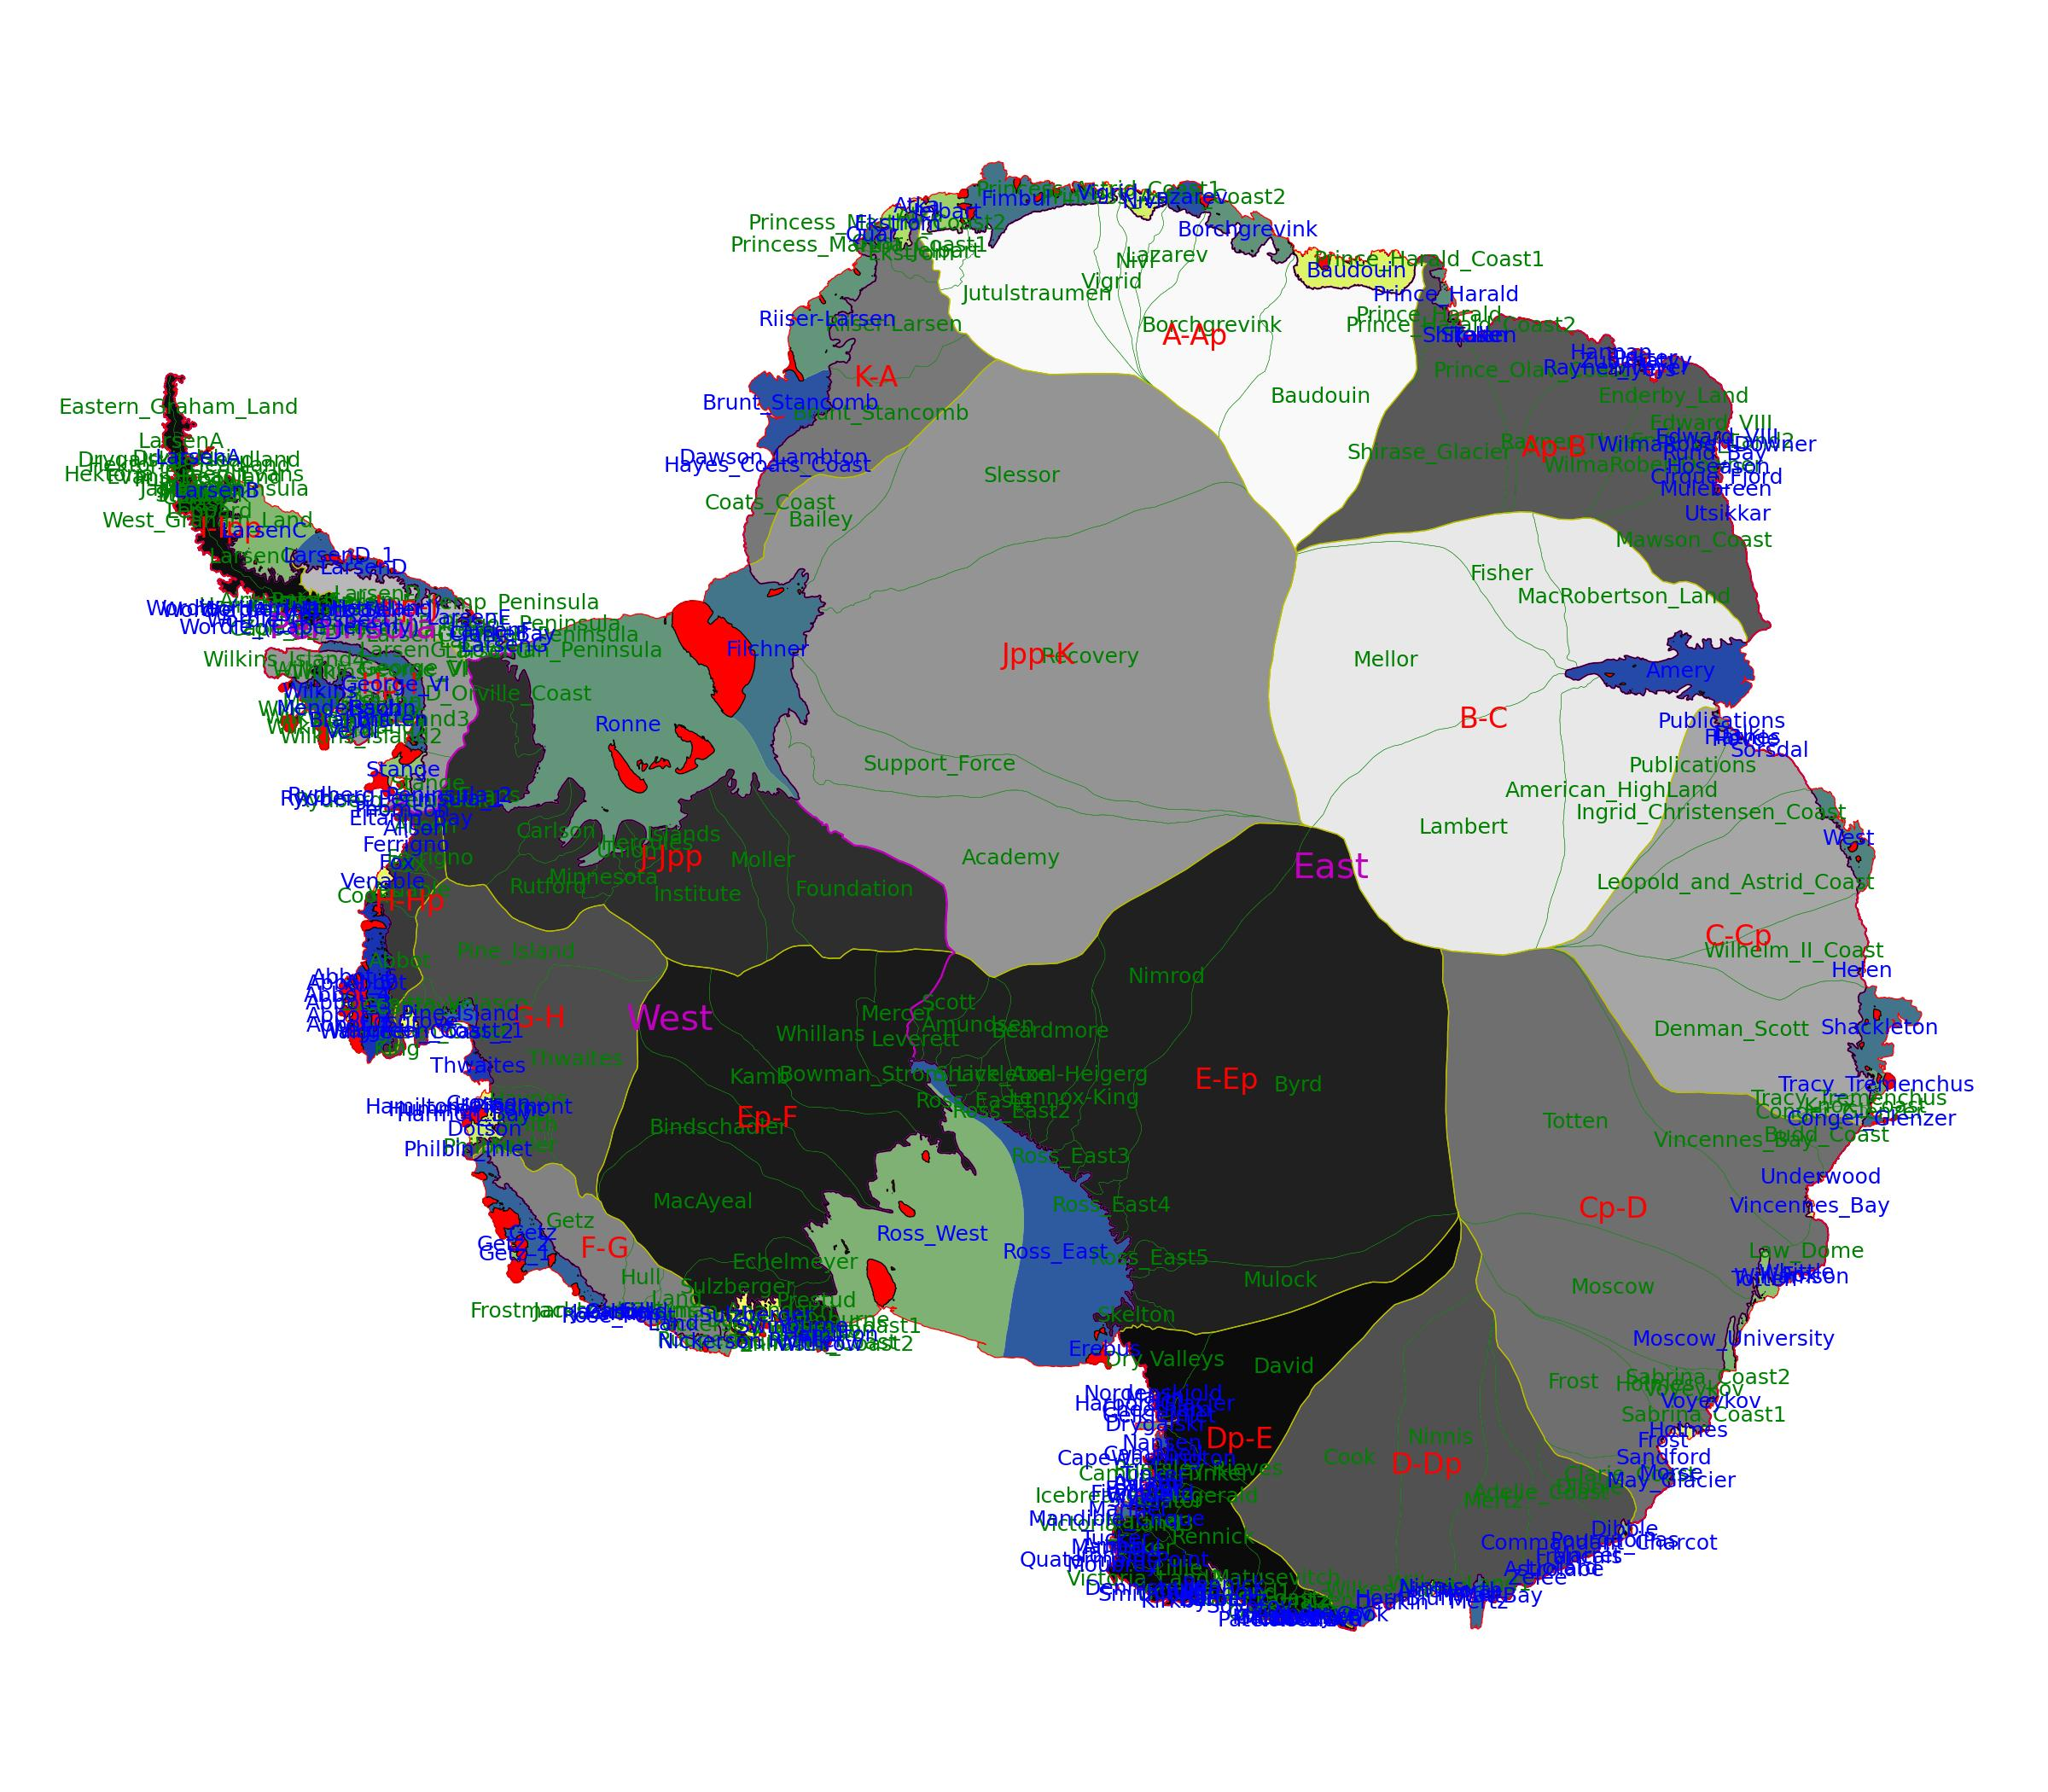

In [3]:
fig, ax = plt.subplots(figsize=[8,7])

gdf_basin.loc[gdf_basin.NAME=='Islands','Subregions'] = 'Islands'
gdf_basin.plot(column='Subregions', cmap=cmc.grayCS, ax=ax)
gdf_basin[gdf_basin.NAME=='Islands'].plot(color='r', ax=ax)
gdf_basin.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_basin.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=6),axis=1)
gdf_regions = gdf_basin.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_regions = gdf_regions[gdf_regions.Regions != 'Islands']
gdf_regions.boundary.plot(color='y', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)
gdf_mainregions = gdf_regions.dissolve('Regions')[['geometry']].reset_index()
gdf_mainregions.boundary.plot(color='m', ax=ax, lw=0.5)
gdf_mainregions.apply(lambda x: ax.annotate(text=x['Regions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='m',fontsize=10),axis=1)

gdf_shelf.plot(column='NAME', cmap=cmc.imolaS, ax=ax)
gdf_shelf.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='b',fontsize=6),axis=1)

gdf_ground.boundary.plot(color='k', ax=ax, lw=0.3)

gdf_coast.boundary.plot(color='r', ax=ax, lw=0.3)

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/input_data_Antarctica.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### find unresolved shelf associations and unassociated shelves

In [4]:
def find_shelf_errors(gdf_shelf, gdf_basin):
    shelf_names = np.array(gdf_shelf.NAME)
    asso_shelves = []
    for shelves in gdf_basin.Asso_Shelf:
        if type(shelves) is not float:
            asso_shelves += shelves.split('/')
    asso_shelves = np.unique(np.array(asso_shelves))
    asso_shelves = np.array([x for x in asso_shelves if len(x)>0])
    unresolved_associations = np.setdiff1d(asso_shelves, shelf_names)
    print('Unresolved shelf associations:', unresolved_associations)
    unassociated_shelves = np.setdiff1d(shelf_names, asso_shelves)
    print('Unassociated shelves:', unassociated_shelves)
    return unresolved_associations, unassociated_shelves
    
unresolved_associations, unassociated_shelves = find_shelf_errors(gdf_shelf, gdf_basin)

Unresolved shelf associations: ['Moscow' 'Ronne_Ice' 'Wordie']
Unassociated shelves: ['Abbot_1' 'Abbot_2' 'Abbot_3' 'Abbot_4' 'Abbot_5' 'Abbot_6' 'Erebus'
 'Getz_1' 'Getz_2' 'Hamilton_Piedmont' 'Harmon_Bay' 'Holt' 'Hummer_Point'
 'LarsenD_1' 'Moscow_University' 'Ronne' 'Thomson'
 'Wordie_(Airy_Rotz_Seller)' 'Wordie_(Cape_Jeremy)' 'Wordie_(Harriott)'
 'Wordie_(Harriott_Headland)' 'Wordie_(Prospect)']


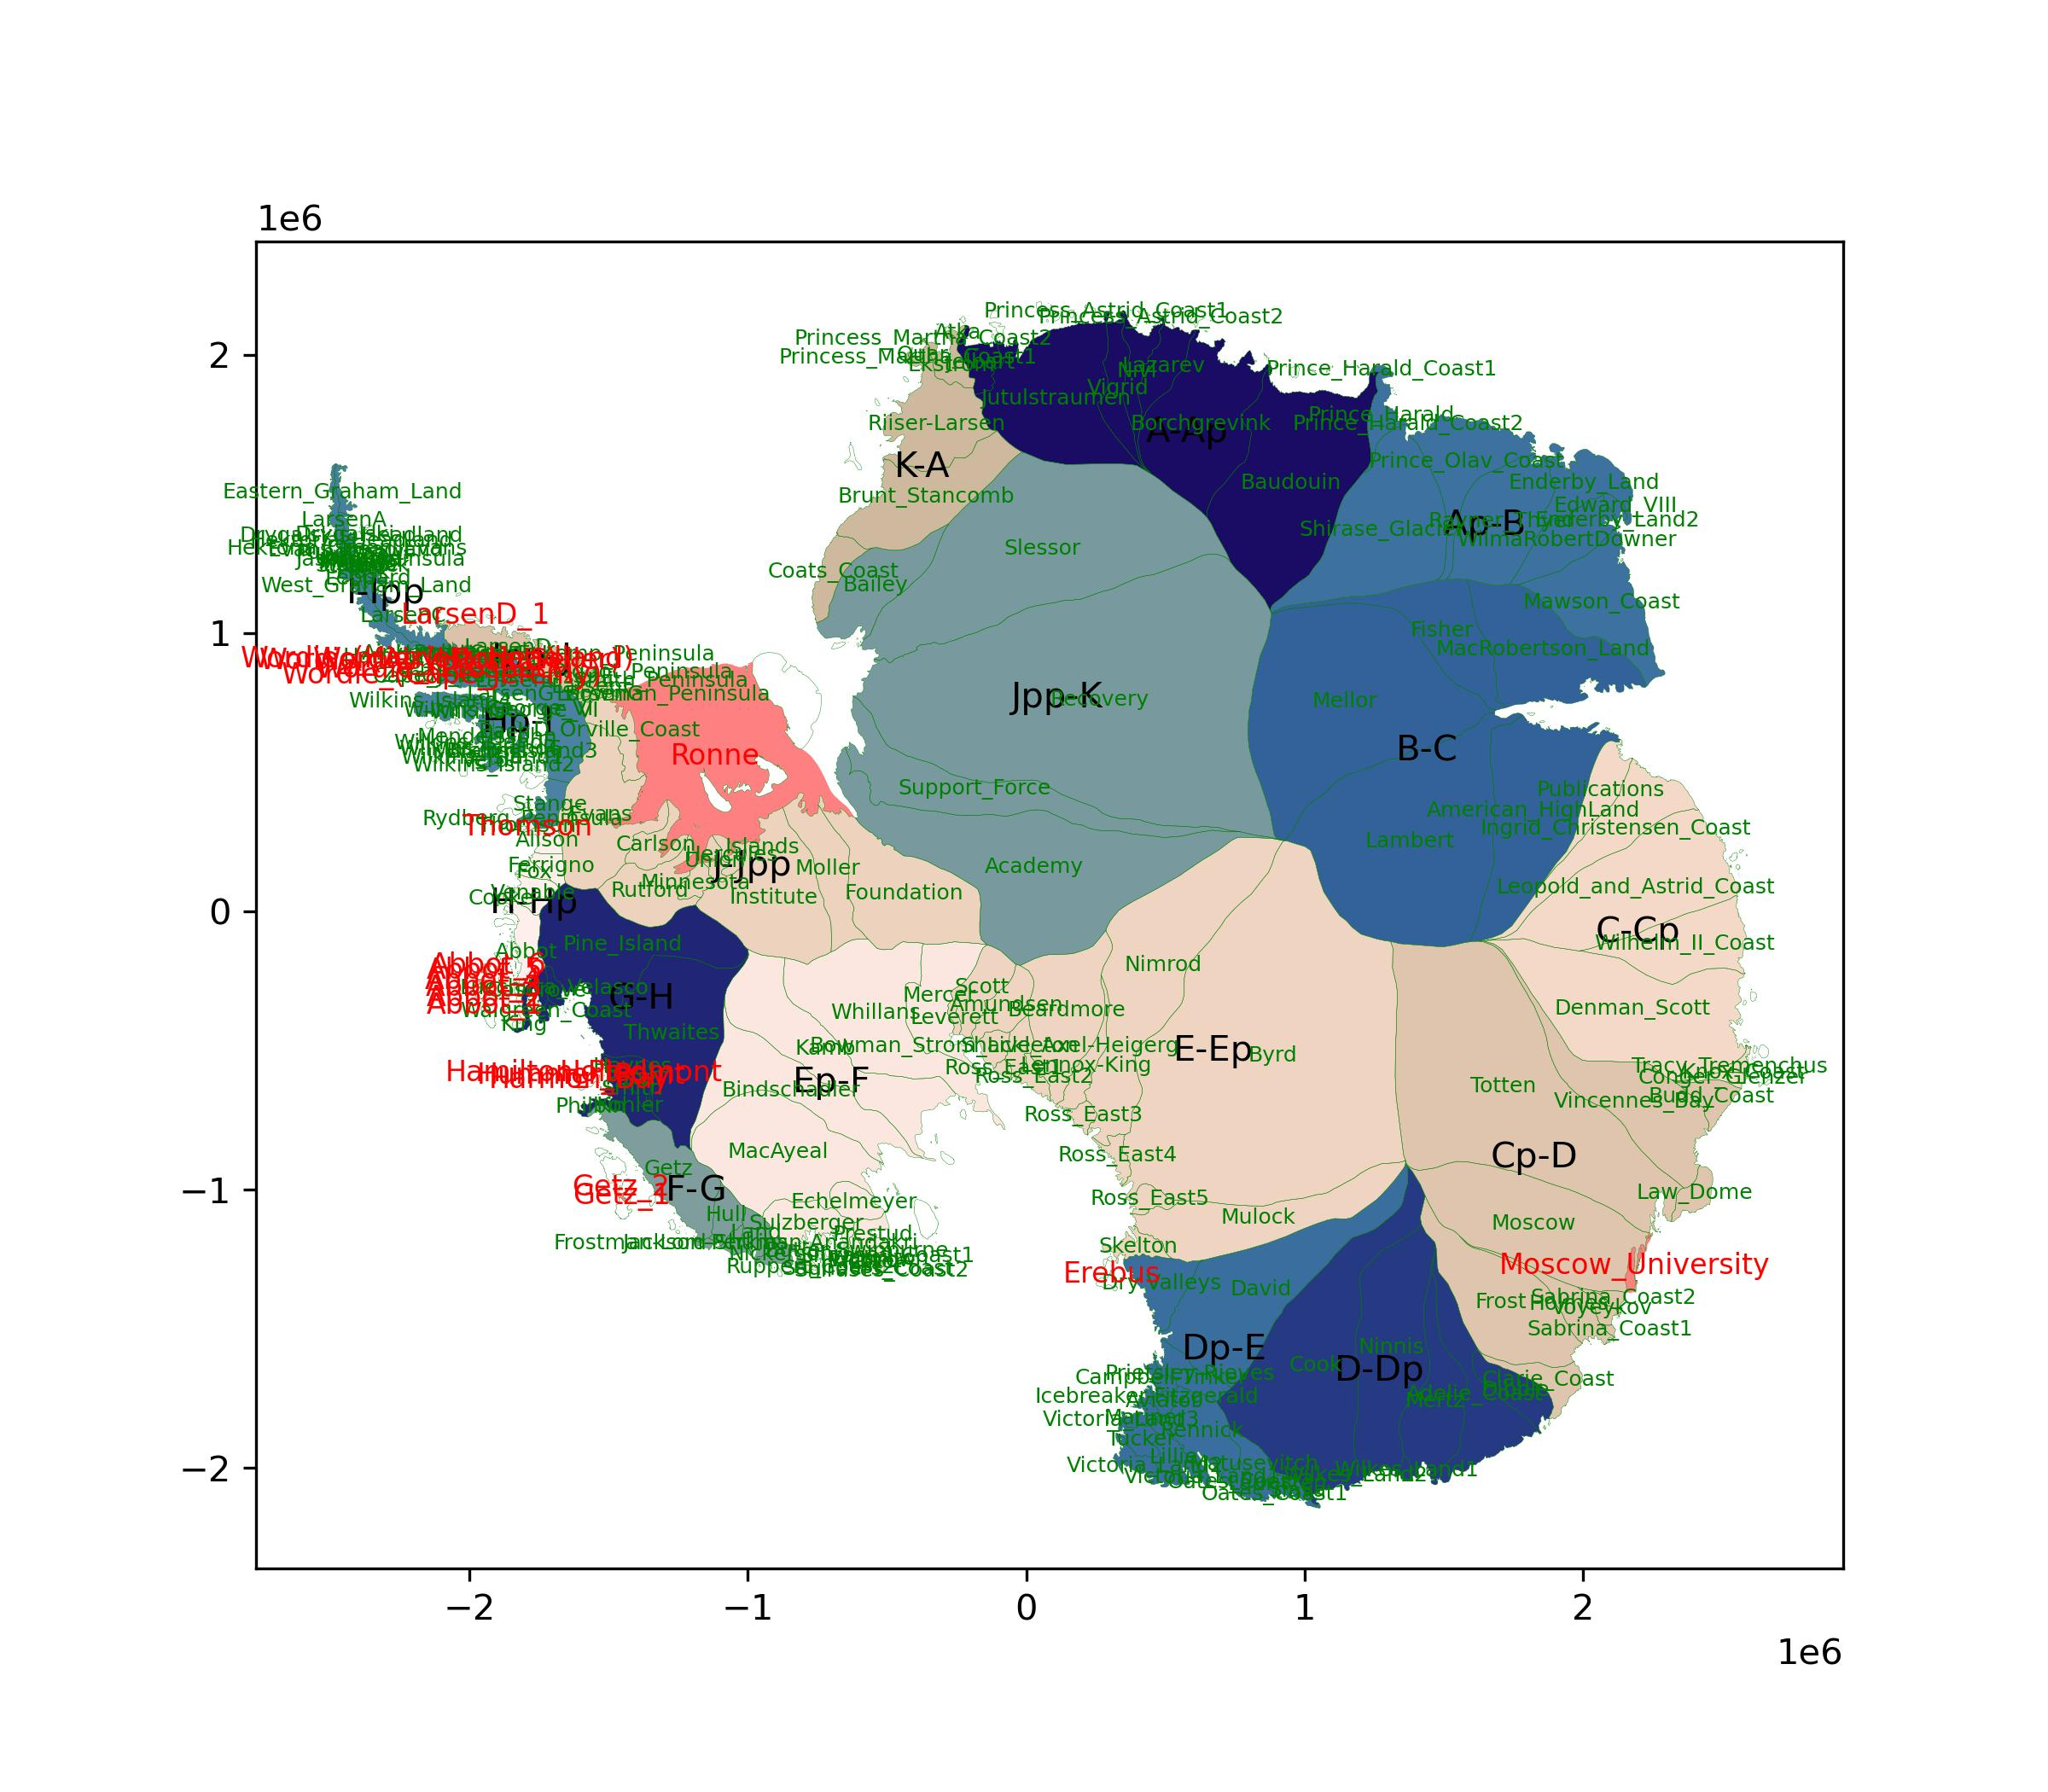

In [5]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_regions.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_regions.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='k',fontsize=10),axis=1)
gdf_basin.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_basin.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=6),axis=1)
gdf_shelf['not_asso'] = gdf_shelf.apply(lambda x: x.NAME in unassociated_shelves, axis=1)
gdf_shelf[gdf_shelf.not_asso].plot(color=(1,0.5,0.5), ax=ax)
gdf_shelf[gdf_shelf.not_asso].apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1);

# show plot and print info
plotname = 'plots/unassociated_shelves_Antarctica.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### fix ice shelf association inconsistencies

In [6]:
gdf_basin.reset_index(inplace=True, drop=True)

# rename the ice shelves that are in the 
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    if type(asso_shelf) is not float:
        
        # replace 'Ronne_Ice' with 'Ronne'
        if 'Ronne_Ice' in asso_shelf: 
            gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Ronne_Ice', 'Ronne')
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
        # replace 'Moscow' with 'Moscow_University'
        if ('Moscow' in asso_shelf) and ('Moscow_University' not in asso_shelf): 
            gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Moscow', 'Moscow_University')
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
        # replace 'Wordie' with the associated basin names that have shelves (all but Fleming)
        if ('Wordie' in asso_shelf) and ('Wordie_' not in asso_shelf): 
            if 'Fleming' in thisname:
                gdf_basin.loc[i, 'Asso_Shelf'] = np.nan
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Wordie', 'Wordie_(%s)'%thisname)
                print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
                
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    
    # add Abbot, LarsenD, Thomson and Getz island shelves to their respective regions
    if thisname in ['Abbot', 'LarsenD', 'Thomson', 'Getz']:
        to_add = '/'.join([x for x in unassociated_shelves if ((thisname in x) and (x not in str(asso_shelf)))])
        if len(to_add) > 0: 
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
    # add Erebus shelf to Skelton basin
    if thisname == 'Skelton':
        to_add = 'Erebus'
        if to_add not in str(asso_shelf):
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
    # add Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point shelves to Kohler basin
    if thisname == 'Kohler':
        to_add = 'Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point'
        if to_add not in str(asso_shelf):
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])

# there are two Fox ice shelves, one in EAIS and one in WAIS, replace with Fox_East and Fox_West
gdf_shelf.loc[gdf_shelf.NAME == 'Fox', 'NAME'] = gdf_shelf.loc[gdf_shelf.NAME == 'Fox'].apply(lambda x: '%s_%s' % (x.NAME, x.Regions), axis=1)
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    if ('Fox' in str(asso_shelf)) and ('Fox_' not in str(asso_shelf)):
        gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Fox', '%s_%s' % (asso_shelf, gdf_basin.loc[i].Regions))
        print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])

# check that there is no more unresolved ice shelves
print(' ')
unresolved_associations, unassociated_shelves = find_shelf_errors(gdf_shelf, gdf_basin)

Moscow East Cp-D : Moscow --> Moscow_University
Rutford West J-Jpp : Ronne_Ice --> Ronne
Carlson West J-Jpp : Ronne_Ice --> Ronne
Evans West J-Jpp : Ronne_Ice --> Ronne
Harriott_Headland Peninsula I-Ipp : Wordie --> Wordie_(Harriott_Headland)
Prospect Peninsula I-Ipp : Wordie --> Wordie_(Prospect)
Foundation West J-Jpp : Ronne_Ice --> Ronne
Minnesota West J-Jpp : Ronne_Ice --> Ronne
Union West J-Jpp : Ronne_Ice --> Ronne
Hercules West J-Jpp : Ronne_Ice --> Ronne
Moller West J-Jpp : Ronne_Ice --> Ronne
Institute West J-Jpp : Ronne_Ice --> Ronne
D_Orville_Coast West J-Jpp : Ronne_Ice --> Ronne
Airy_Rotz_Seller Peninsula I-Ipp : Wordie --> Wordie_(Airy_Rotz_Seller)
Cape_Jeremy Peninsula Hp-I : Wordie --> Wordie_(Cape_Jeremy)
Harriott Peninsula I-Ipp : Wordie --> Wordie_(Harriott)
Skelton East E-Ep : Ross_East --> Ross_East/Erebus
Kohler West G-H : Dotson --> Dotson/Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point
Getz West F-G : Getz --> Getz/Getz_1/Getz_2
Abbot West H-Hp : Abbot --> Abbot/

### merge subregions with associated ice shelves and ajdacent islands

In [7]:
gdf_basin.loc[gdf_basin.NAME=='Islands','Subregions'] = 'Islands'
def get_shelves_list(x):
    if type(x.Asso_Shelf) is not float: return x.Asso_Shelf.split('/')
    else: return []
gdf_basin['Asso_Shelf'] = gdf_basin.apply(get_shelves_list, axis=1)
gdf_regions = gdf_basin.dissolve('Subregions')[['Regions', 'geometry']]
regions_group = gdf_basin.groupby(by="Subregions")
gdf_regions['shelves'] = regions_group['Asso_Shelf'].apply(lambda x: np.unique([item for sub in x for item in sub if item]))
gdf_regions.reset_index(inplace=True)
gdf_regions['NAME'] = gdf_regions.Subregions
gdf_regions['TYPE'] = 'GR'

gdf_shelf.set_index('NAME', inplace=True)

shlvs = []
for i in range(len(gdf_regions)):
    r = gdf_regions.iloc[i]
    for shelf in r.shelves:
            sh = gdf_shelf.loc[shelf]
            gdf_regions.loc[len(gdf_regions)] = [r.Subregions, sh.Regions, sh.geometry, np.nan, shelf, sh.TYPE]
            shlvs.append(shelf)

gdf_regions.drop('shelves', axis=1, inplace=True)
gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands'].copy()

# add each island to the subregion (including shelves) that overlaps most with the island's boundary
for geom in gdf_regions[gdf_regions.NAME == 'Islands'].iloc[0].geometry.geoms:
    r = gdf_merged[gdf_merged.boundary.intersects(geom.boundary)]
    if len(r) > 0:
        if len(r) > 1:
            r = r.iloc[r.intersection(geom.boundary).length.argmax()]
        else:
            r = r.iloc[0]
        gdf_regions.loc[len(gdf_regions)] = [r.Subregions, r.Regions, geom, 'island', 'IS']

gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index().copy().set_crs('EPSG:3031')

In [8]:
gdf_merged.loc[len(gdf_merged)] = gdf_merged.loc[15]
gdf_merged = gdf_merged.drop(15).reset_index(drop=True)
gdf_merged

Subregions    Regions                                           geometry
0        A-Ap       East  POLYGON ((-217949.577 2132201.233, -218200.116...
1        Ap-B       East  POLYGON ((1580144.570 1194398.841, 1546993.222...
2         B-C       East  POLYGON ((906081.004 260430.871, 899939.375 26...
3        C-Cp       East  POLYGON ((2572424.590 -167174.927, 2572674.727...
4        Cp-D       East  POLYGON ((1999424.606 -1689425.565, 1999424.69...
5        D-Dp       East  POLYGON ((1132475.353 -2058817.367, 1131708.55...
6        Dp-E       East  POLYGON ((440222.827 -2038172.048, 441081.119 ...
7        E-Ep       East  POLYGON ((306799.994 -1293174.603, 306675.202 ...
8        Ep-F       West  POLYGON ((-672878.546 -1223262.434, -671299.75...
9         F-G       West  POLYGON ((-1423449.652 -1082800.420, -1424699....
10        G-H       West  POLYGON ((-1652777.439 -364020.965, -1652631.4...
11       H-Hp       West  POLYGON ((-1951483.805 -340461.956, -1950298.6...
12       Hp-I  Peninsula  POLYGON ((-2106450.256 552575.388, -2107075.14...
13      I-Ipp  Peninsula  POLYGON ((-2399199.854 1335950.332, -2401075.3...
14      Ipp-J  Peninsula  POLYGON ((-2030345.890 1137128.451, -2029093.8...
15      J-Jpp       West  POLYGON ((-1001836.505 881470.846, -1001528.02...
16      Jpp-K       East  POLYGON ((-810257.817 1011634.942, -809669.190...
17        K-A       East  POLYGON ((-701824.844 1327324.998, -702074.958...
18    Islands    Islands  MULTIPOLYGON (((-2107449.980 552450.143, -2107...

In [9]:
gdf_merged = gdf_merged.set_crs('EPSG:3031')
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands']
gdf_merged.to_file('ANT_basins_merged.geojson', driver="GeoJSON", crs='EPSG:3031') 
gdf_merged.to_file('shapefiles/ANT_basins_merged.shp') 

### Plot the resulting regions

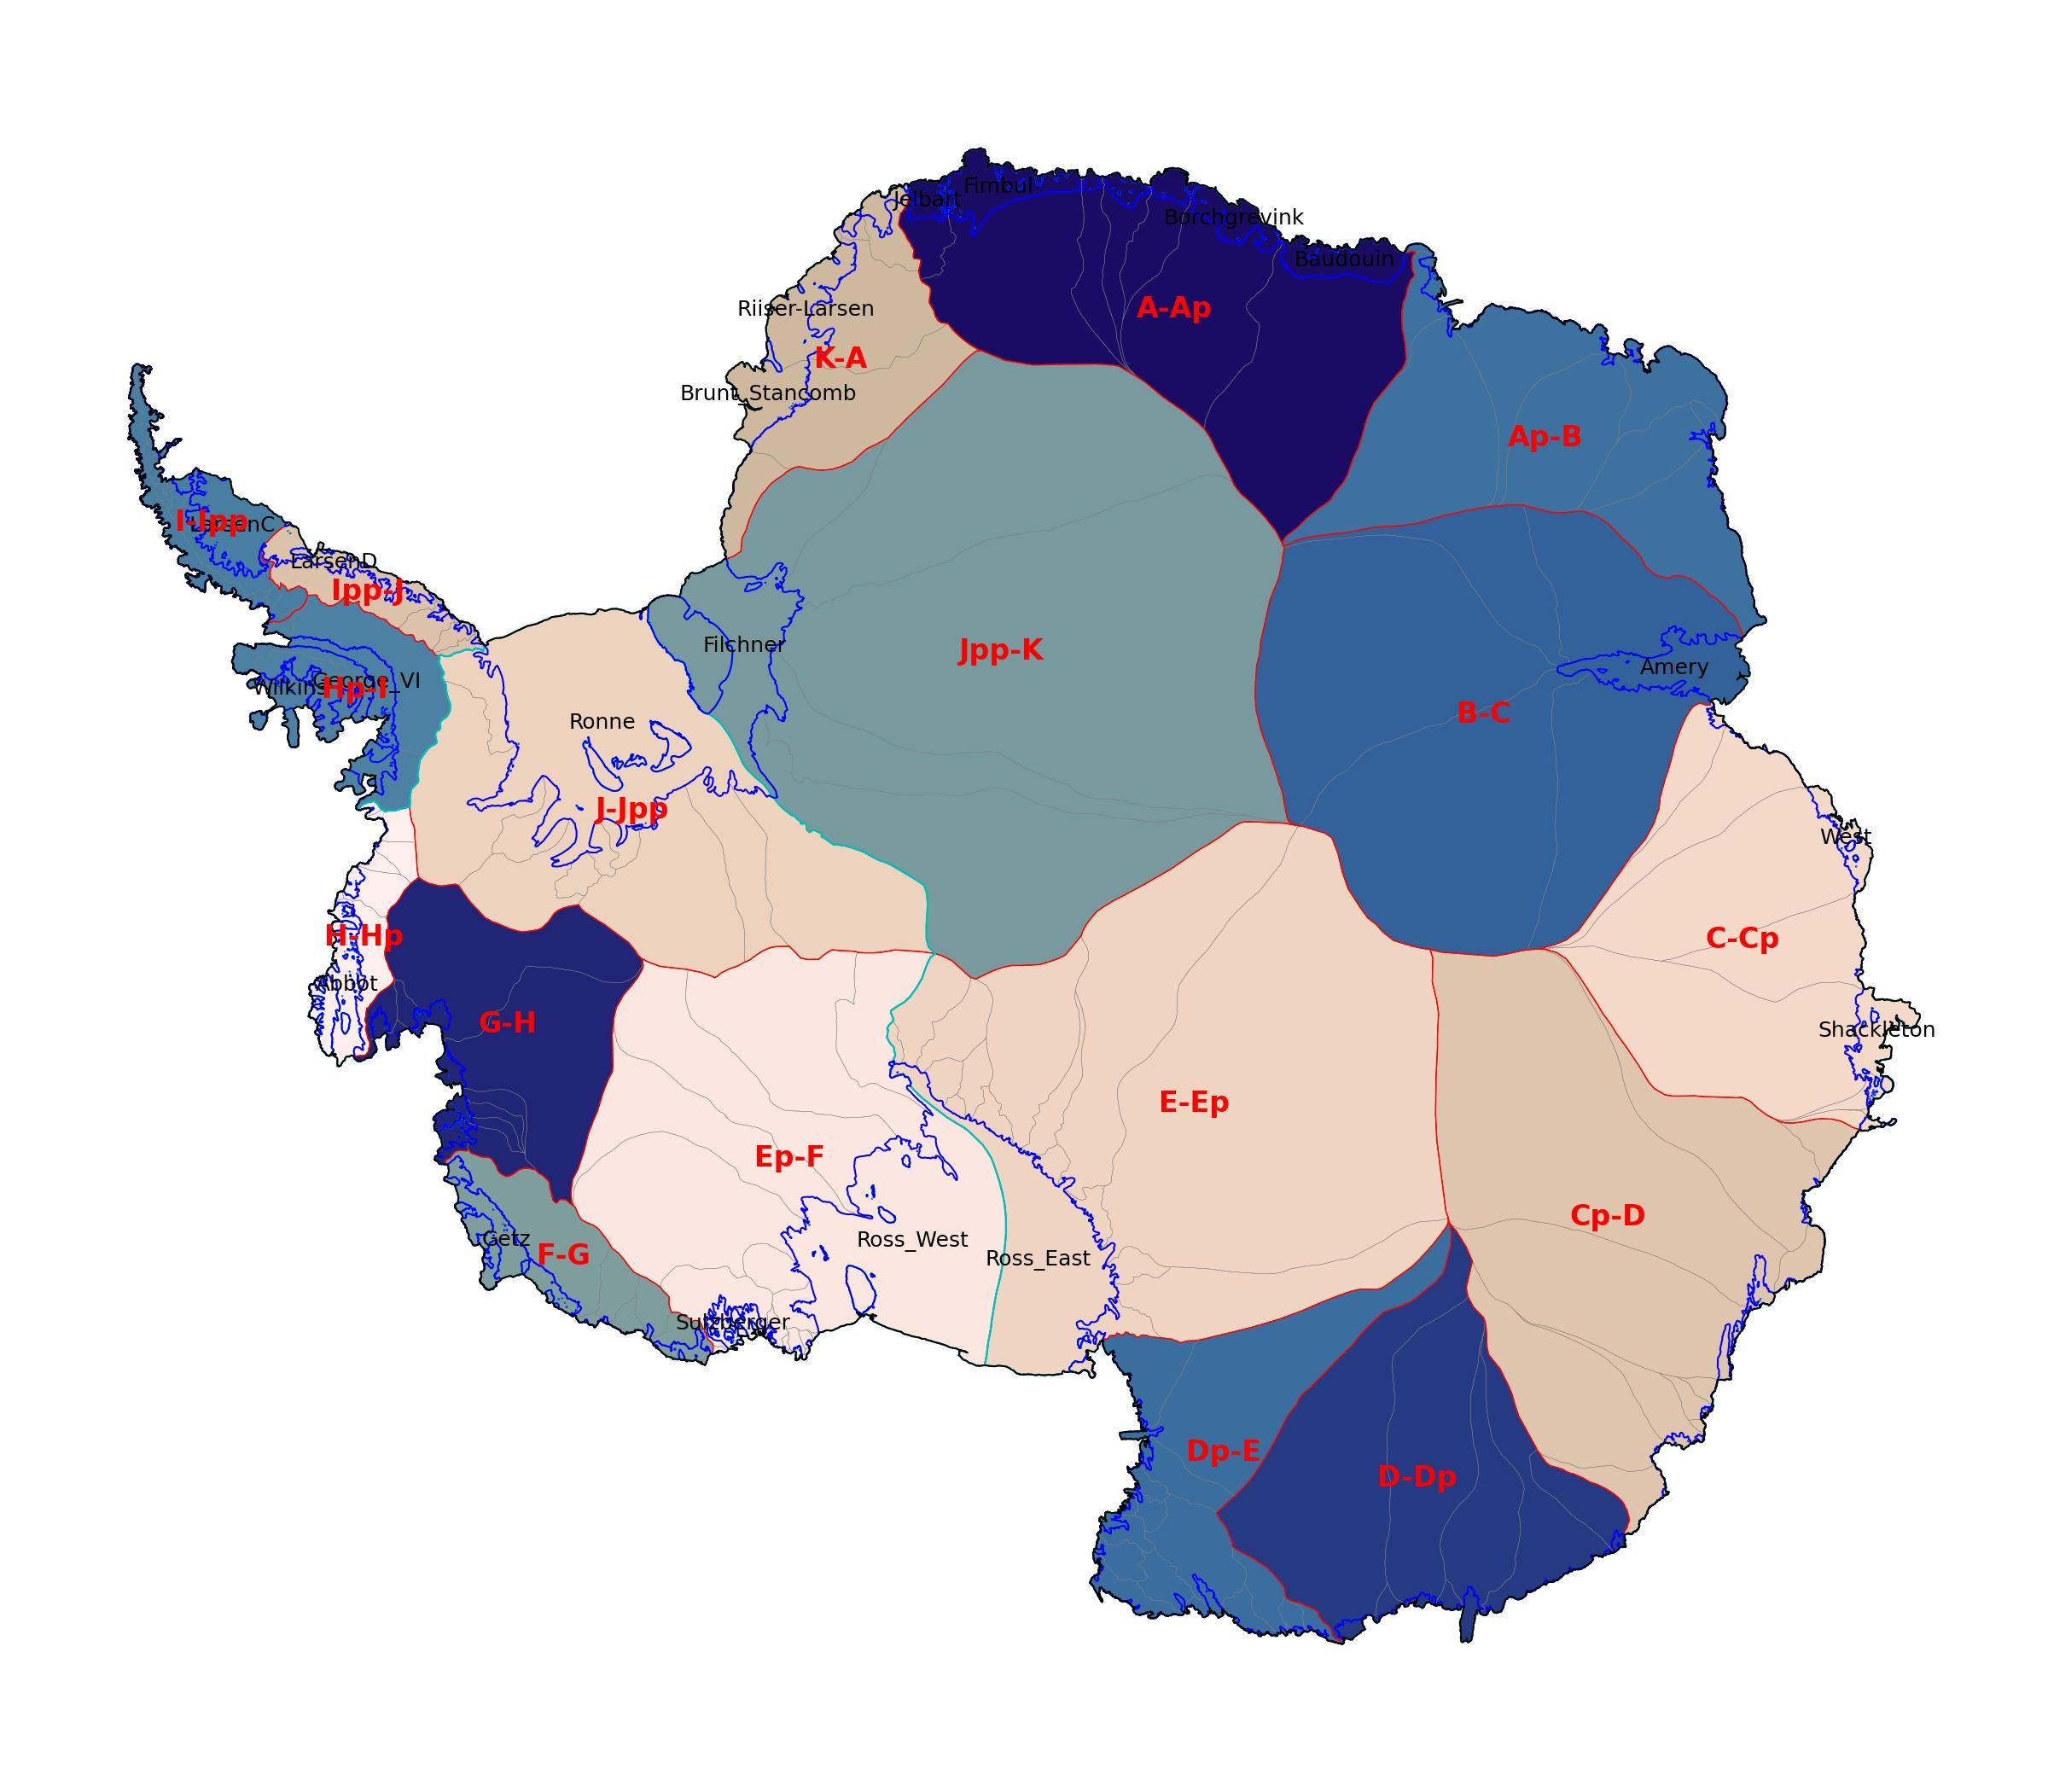

In [10]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_merged.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)

gdf_mainregions = gdf_regions.dissolve('Regions')[['geometry']].reset_index()
gdf_basin.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)

def add_shelf_label(shelf, min_area=1e10):
    if shelf.geometry.area > min_area: 
        ax.annotate(text=shelf['NAME'], xy=shelf.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6)
gdf_shelf.reset_index().apply(add_shelf_label, axis=1);

gdf_merged.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/merged_basins_Antarctica.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### Threshold by elevation
Could use better elevation thresholds? Estimated from data in 
- Tuckett, P., Ely, J., Sole, A., Livingstone, S., Jones, J., Lea, J., & Gilbert, E. (2022). Continent-scale mapping reveals a rise in East Antarctic surface meltwater.
- Tuckett, P. A., Ely, J. C., Sole, A. J., Lea, J. M., Livingstone, S. J., Jones, J. M., & van Wessem, J. M. (2021). Automated mapping of the seasonal evolution of surface meltwater and its links to climate on the Amery Ice Shelf, Antarctica. The Cryosphere, 15(12), 5785-5804.

In [11]:
elevation_threshold = 1000
coast_buffer = 1000
fn_dem = 'DEMs/rema_mosaic_1km_v2.0_filled_cop30_dem.tif'

def threshold_geotiff_to_geodataframe(input_path, threshold):
    with rio.open(input_path) as src:
        profile = src.profile
        data = src.read(1)  # Read the first band
        thresholded_data = data < threshold
        mask = thresholded_data.astype('uint8')
        shapes = features.shapes(mask, transform=src.transform)
        polygons = []
        for geom, value in shapes:
            if value == 1:
                polygons.append(shape(geom))
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile['crs']).dissolve()[['geometry']].reset_index(drop=True)
        gdf['geometry'] = gdf.geometry.simplify(src.res[0], preserve_topology=True)
        return gdf

gdf_dem = threshold_geotiff_to_geodataframe(fn_dem, elevation_threshold)
gdf_thresh = gdf_merged.copy()
gdf_thresh['geometry'] = gdf_thresh.intersection(gdf_dem.iloc[0].geometry)
boundary = gdf_merged.intersection(gdf_coast.iloc[0].geometry.boundary.buffer(coast_buffer))
gdf_thresh['geometry'] = gdf_thresh.union(boundary)

def fill_holes(x):
    if x.geometry.geom_type == 'Polygon':
        poly = x.geometry
        if poly.interiors: 
            return Polygon(list(poly.exterior.coords))
        else: 
            return poly
    if x.geometry.geom_type == 'MultiPolygon':
        for poly in x.geometry.geoms:
            if poly.interiors: 
                poly_filled = Polygon(list(poly.exterior.coords))
            else: 
                poly_filled = poly
            if poly_filled.intersects(gdf_coast.boundary.geometry.iloc[0]):
                return poly_filled
        
gdf_thresh['geometry'] = gdf_thresh.apply(fill_holes, axis=1)

In [12]:
gdf_thresh.to_file('ANT_basins_thresh%i.geojson' % elevation_threshold , driver="GeoJSON", crs='EPSG:3031')
gdf_thresh.to_file('shapefiles/ANT_basins_thresh%i.shp' % elevation_threshold) 

### Plot the resulting regions that are likely to have surface melt

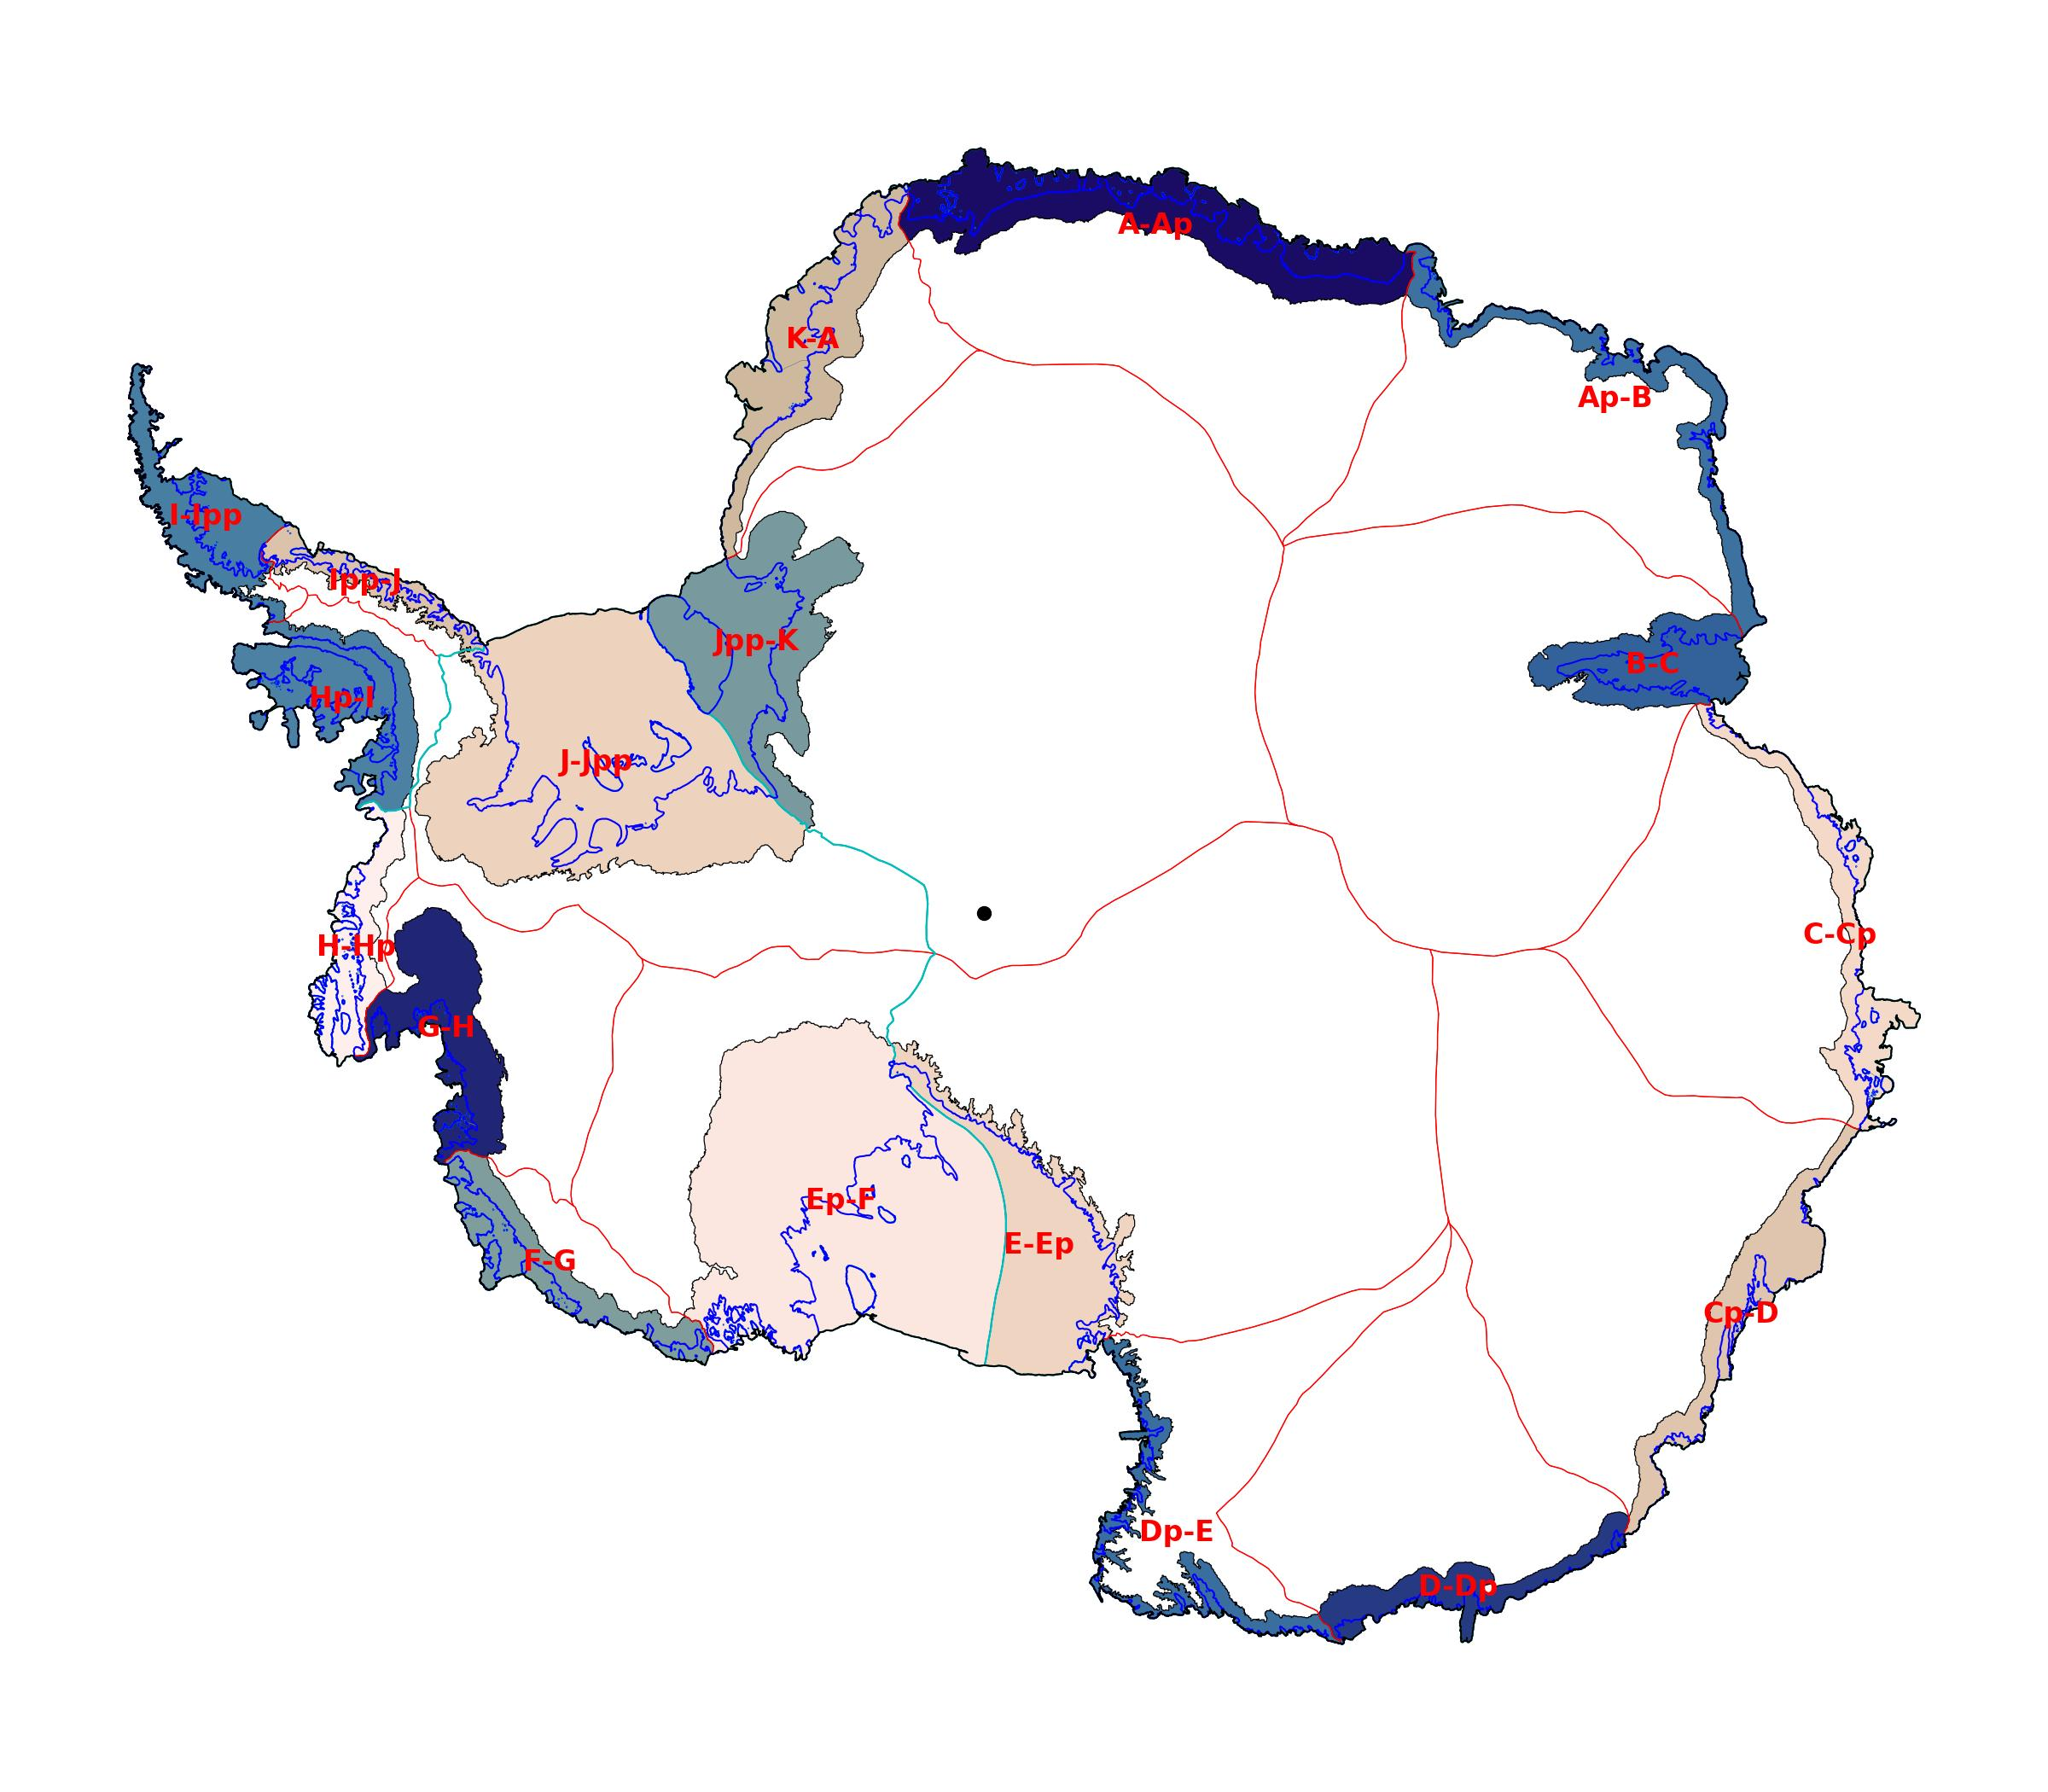

In [13]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
gdf_thresh.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=10,color='k')

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/thresholded_basins_Antarctica.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

In [14]:
ant_gdf_thresh_nofix = gdf_thresh.copy()
gdf_thresh_copy = gdf_thresh.copy().set_index('Subregions')
ross_geom = gdf_thresh_copy.loc[['E-Ep', 'Ep-F']].dissolve()[['geometry']]
ply_ross_east = Polygon([(1,-1),(1,-3e6),(3e6,-3e6),(3e6,-1),(1,-1)])
ply_ross_west = Polygon([(-1,-1),(-3e6,-1),(-3e6,-3e6),(-1,-3e6),(-1,-1)])
ross_east = gpd.GeoDataFrame(geometry=[ply_ross_east], crs=gdf_thresh.crs)
ross_west = gpd.GeoDataFrame(geometry=[ply_ross_west], crs=gdf_thresh.crs)
gdf_thresh.loc[(gdf_thresh.Subregions=='E-Ep') | (gdf_thresh.Subregions=='Ep-F'), 'geometry'] = ross_geom.geometry.loc[0]

### Write polygons to geojson files for NSIDC queries

In [15]:
simplify_tol = 10000 # 10 km 
gdf_thresh_simple = gdf_thresh.copy()
gdf_thresh['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh_simple.apply(fill_holes, axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh_simple.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)

In [16]:
# change Ross basins so that NSIDC doesn't get tripped up by the +- 180 degrees wrap
gdf_thresh.loc[gdf_thresh.Subregions=='E-Ep', 'geometry'] = gpd.clip(
    gdf_thresh.loc[gdf_thresh.Subregions=='E-Ep', 'geometry'],
    ross_east).iloc[0]
gdf_thresh.loc[gdf_thresh.Subregions=='Ep-F', 'geometry'] = gpd.clip(
    gdf_thresh.loc[gdf_thresh.Subregions=='Ep-F', 'geometry'],
    ross_west).iloc[0]

gdf_thresh_simple.loc[gdf_thresh_simple.Subregions=='E-Ep', 'geometry'] = gpd.clip(
    gdf_thresh_simple.loc[gdf_thresh_simple.Subregions=='E-Ep', 'geometry'],
    ross_east).iloc[0]
gdf_thresh_simple.loc[gdf_thresh_simple.Subregions=='Ep-F', 'geometry'] = gpd.clip(
    gdf_thresh_simple.loc[gdf_thresh_simple.Subregions=='Ep-F', 'geometry'],
    ross_west).iloc[0]

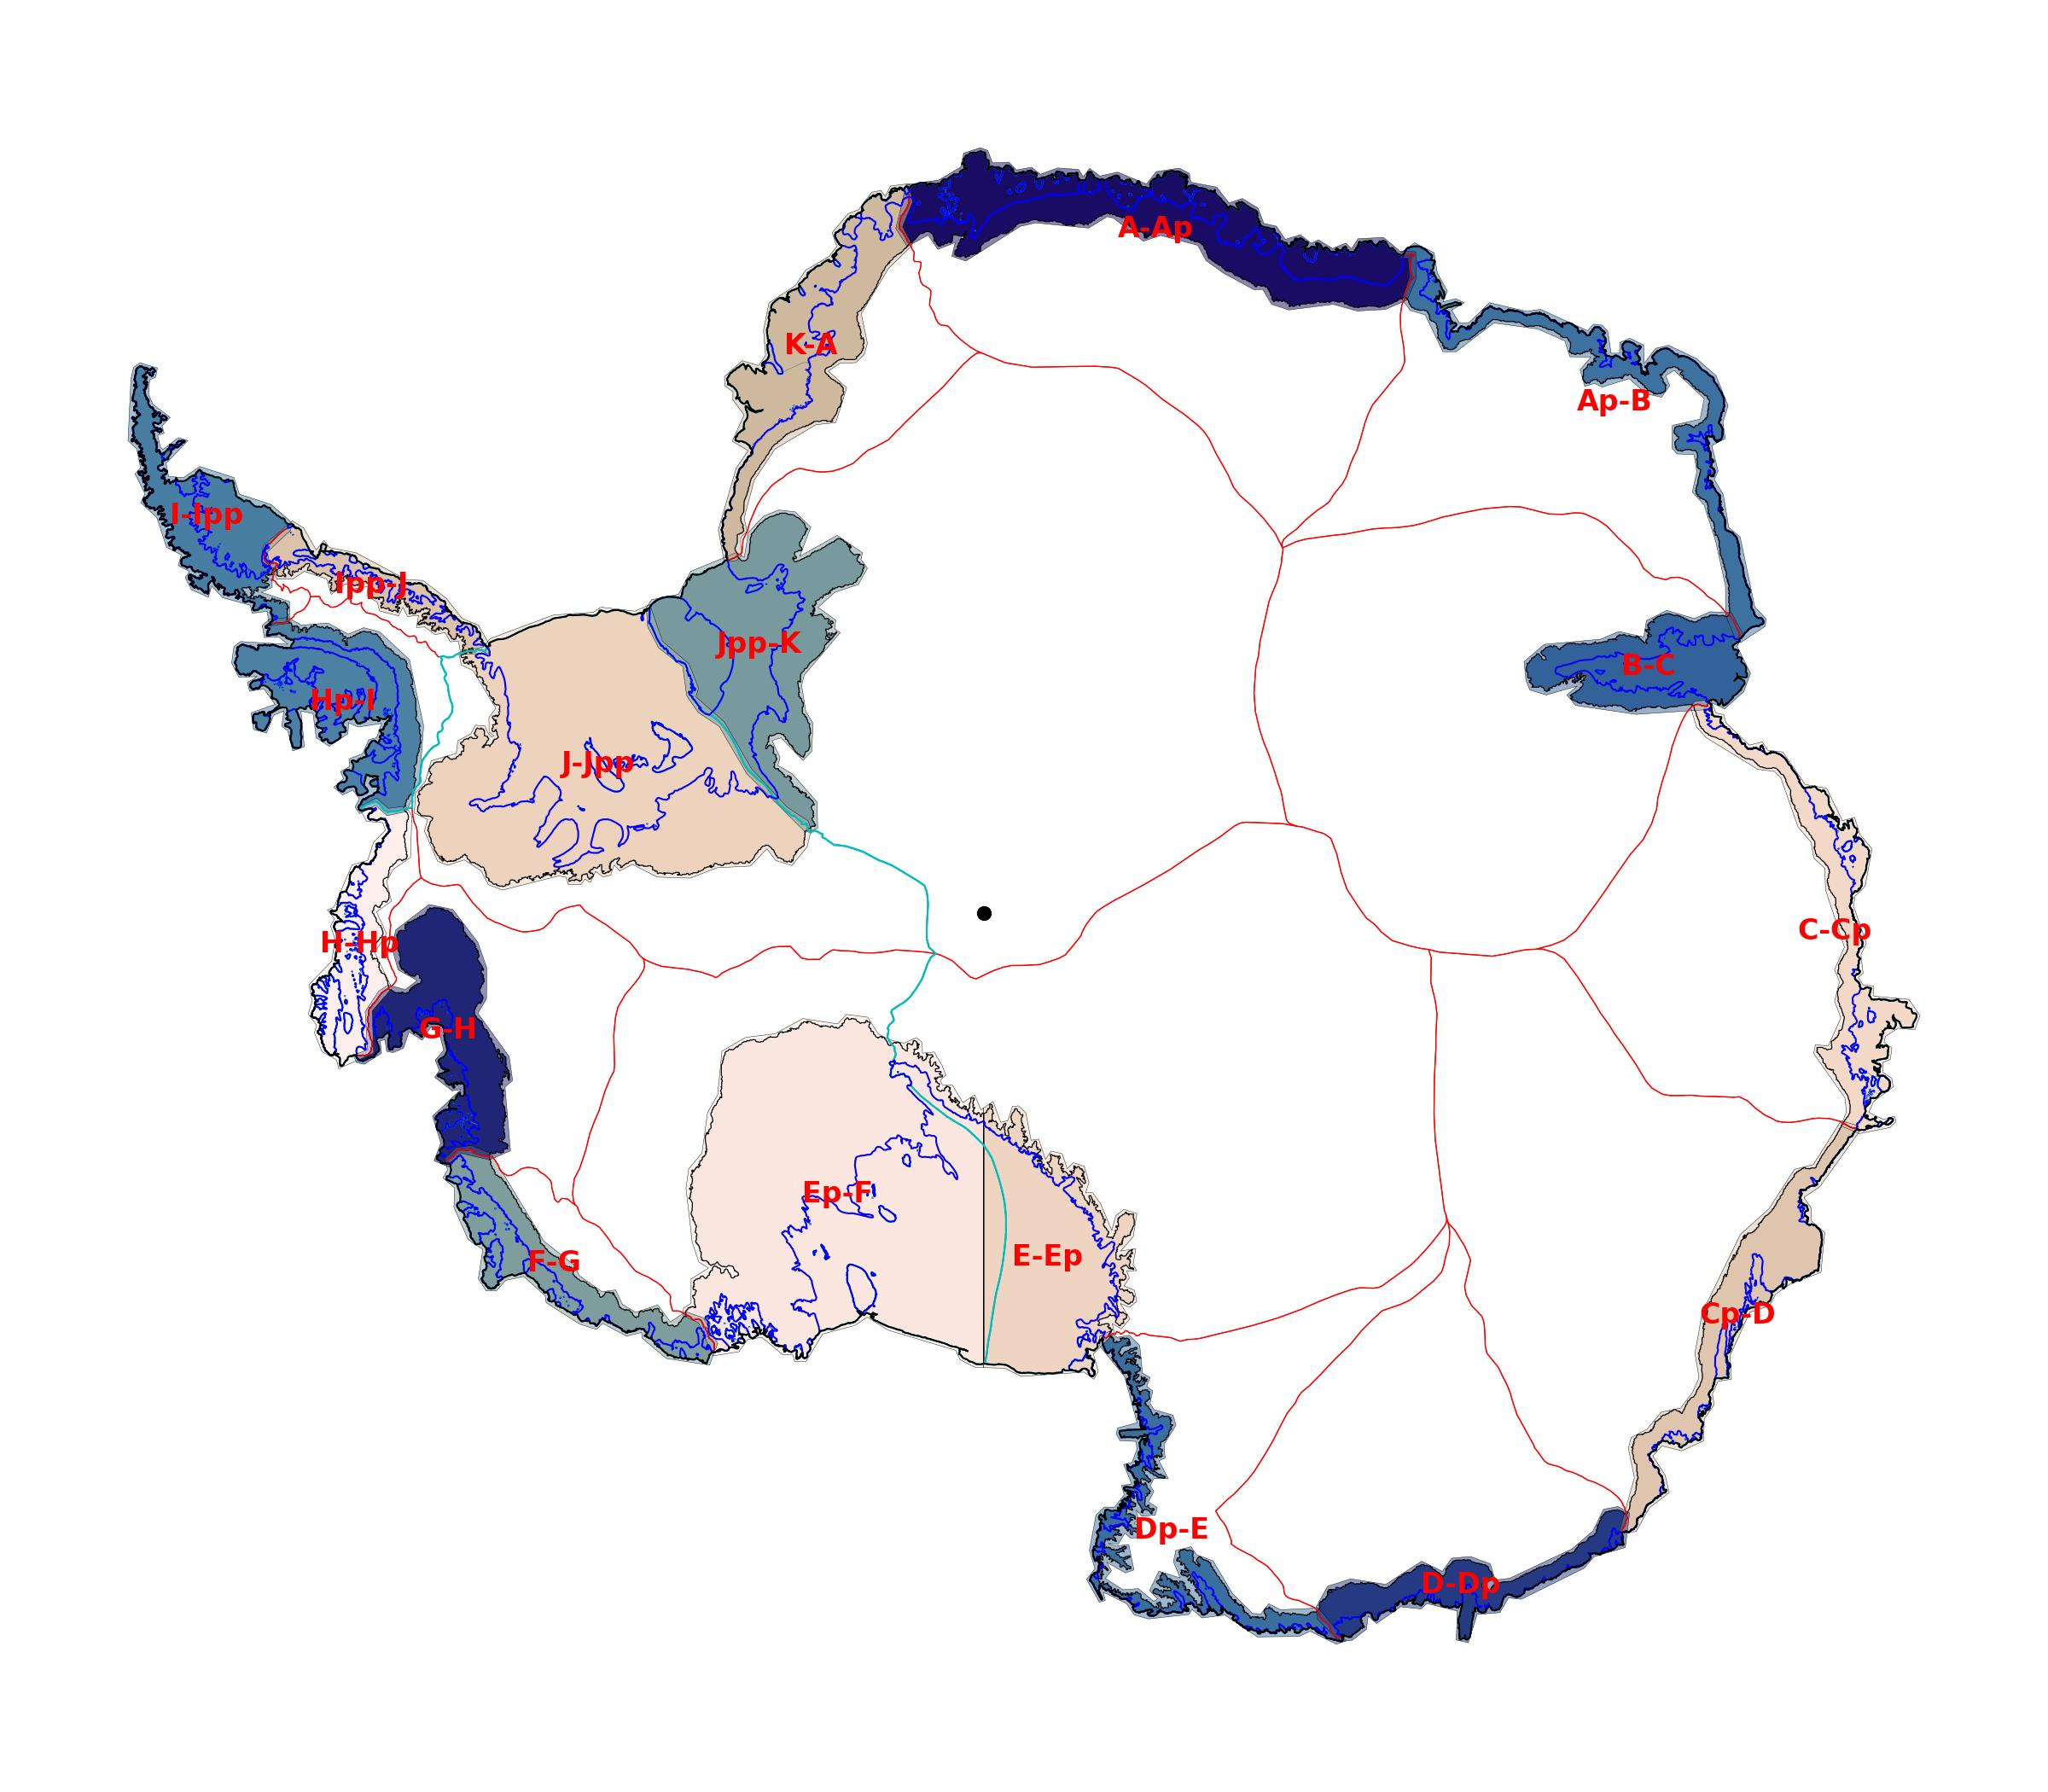

In [17]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_thresh_simple.plot(column='Subregions', cmap=cmc.lapazS, alpha=0.5, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
gdf_thresh_simple.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=10,color='k')

ax.axis('off')
fig.tight_layout()

ant_gdf_thresh = gdf_thresh.copy()
ant_gdf_thresh_simple = gdf_thresh_simple.copy()
ant_gdf_shelf = gdf_shelf.copy()
ant_gdf_merged = gdf_merged.copy()
ant_gdf_mainregions = gdf_mainregions.copy()
ant_gdf_ground = gdf_ground.copy()
ant_gdf_coast = gdf_coast.copy()

# show plot and print info
plotname = 'plots/thresholded_basins_Antarctica_NSIDC_simplified_ross_fix.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

In [18]:
for i in range(len(gdf_thresh)):
    row = gdf_thresh.iloc[i]
    # write full polygon
    poly = orient(row.geometry, sign=1.0)
    out_fn = '../geojsons/ANT_%i_%s_%s.geojson' % (elevation_threshold, row.Regions, row.Subregions)
    gpd.GeoSeries(poly).set_crs(gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

for i in range(len(gdf_thresh_simple)):
    row = gdf_thresh_simple.iloc[i]
    poly = orient(row.geometry, sign=1.0)
    out_fn = '../geojsons/simplified_ANT_%i_%s_%s.geojson' % (elevation_threshold, row.Regions, row.Subregions)
    gpd.GeoSeries(poly).set_crs(gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

Wrote file: ../geojsons/ANT_1000_East_A-Ap.geojson
Wrote file: ../geojsons/ANT_1000_East_Ap-B.geojson
Wrote file: ../geojsons/ANT_1000_East_B-C.geojson
Wrote file: ../geojsons/ANT_1000_East_C-Cp.geojson
Wrote file: ../geojsons/ANT_1000_East_Cp-D.geojson
Wrote file: ../geojsons/ANT_1000_East_D-Dp.geojson
Wrote file: ../geojsons/ANT_1000_East_Dp-E.geojson
Wrote file: ../geojsons/ANT_1000_East_E-Ep.geojson
Wrote file: ../geojsons/ANT_1000_West_Ep-F.geojson
Wrote file: ../geojsons/ANT_1000_West_F-G.geojson
Wrote file: ../geojsons/ANT_1000_West_G-H.geojson
Wrote file: ../geojsons/ANT_1000_West_H-Hp.geojson
Wrote file: ../geojsons/ANT_1000_Peninsula_Hp-I.geojson
Wrote file: ../geojsons/ANT_1000_Peninsula_I-Ipp.geojson
Wrote file: ../geojsons/ANT_1000_Peninsula_Ipp-J.geojson
Wrote file: ../geojsons/ANT_1000_West_J-Jpp.geojson
Wrote file: ../geojsons/ANT_1000_East_Jpp-K.geojson
Wrote file: ../geojsons/ANT_1000_East_K-A.geojson
Wrote file: ../geojsons/simplified_ANT_1000_East_A-Ap.geojson
Wrote

In [19]:
# gdf = gpd.read_file('../geojsons/simplified_ANT_1000_West_Ep-F.geojson')
# # gdf = gpd.read_file('../geojsons/ANT_1000_West_Ep-F.geojson')
# gdf = gpd.read_file('../geojsons/simplified_ANT_1000_East_E-Ep.geojson')
# # gdf = gpd.read_file('../geojsons/ANT_1000_East_E-Ep.geojson')
# np.array(gdf.geometry.iloc[0].exterior.coords.xy[0])
# gdf.explore()

## Greenland

In [3]:
fn = 'shapefiles/Greenland_Basins_PS_v1.4.2.shp'
gdf_basin = gpd.read_file(fn)
gdf_basin['geometry'] = gdf_basin.geometry.buffer(50)
print(gdf_basin.crs)

EPSG:3413


# Use the GRIMP ice mask to include floating ice

Howat, I. (2017). MEaSUREs Greenland Ice Mapping Project (GIMP) Land Ice and Ocean Classification Mask, Version 1 [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/B8X58MQBFUPA. Date Accessed 06-12-2024.

MEaSUREs Greenland Ice Mapping Project (GIMP) Land Ice and Ocean Classification Mask, Version 1
[https://nsidc.org/data/nsidc-0714/versions/1](https://nsidc.org/data/nsidc-0714/versions/1)

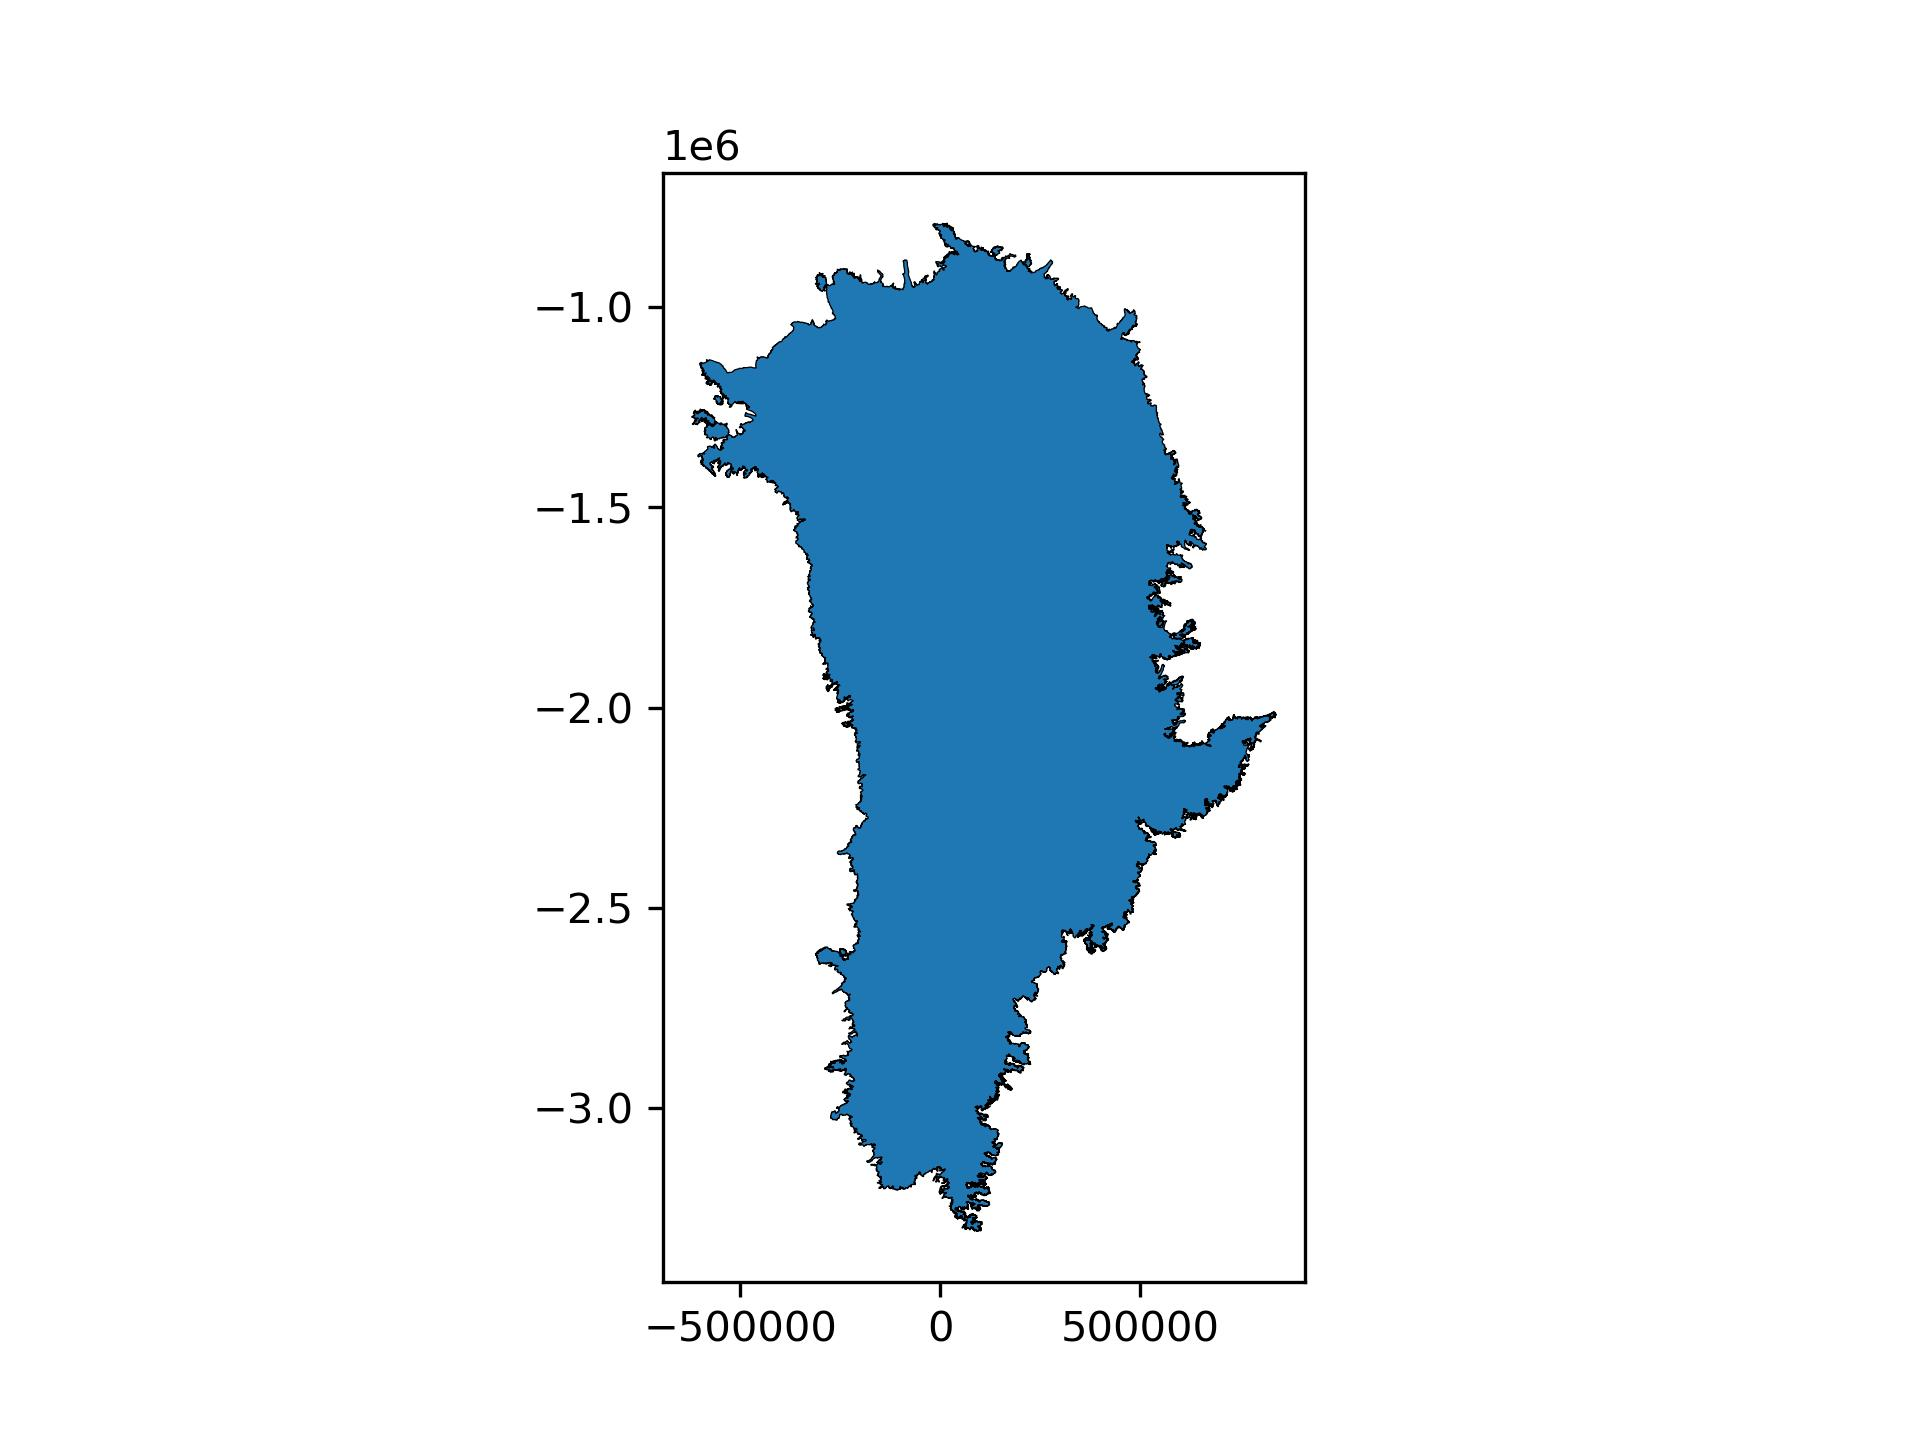

In [4]:
# mask_file = 'GRE_ice_mask/shapefiles/GimpIceMask_90m_2015_v1-2_vector_polygons_scale90.shp'
# gdf_grimp = gpd.read_file(mask_file).to_crs(gdf_basin.crs)
# gdf_grimp = gdf_grimp.dissolve()
# def close_holes(poly):
#         if poly.interiors: return Polygon(list(poly.exterior.coords))
#         else: return poly
# gdf_grimp['geometry'] = gdf_grimp.geometry.apply(lambda x: close_holes(x))
# gdf_grimp['geometry'] = gdf_grimp.simplify(100)[0]
# gdf_grimp['geometry'] = gdf_grimp.geometry.apply(lambda x: close_holes(x))
# gdf_grimp.to_file('GRE_ice_mask/shapefiles/GimpIceMask_90m_2015_v1-2_polygon_processed.shp')
# gdf_grimp.plot()

mask_file = 'GRE_ice_mask/shapefiles/GimpIceMask_90m_2015_v1-2_polygon_processed.shp'
gdf_grimp = gpd.read_file(mask_file).to_crs(gdf_basin.crs)
fig, ax = plt.subplots()
gdf_grimp.plot(ax = ax)
gdf_grimp.boundary.plot(color='k', ax=ax, lw=0.3)

# show plot and print info
plotname = 'plots/grimp_icemask_input.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

In [8]:
gdf_gris

SUBREGION1                        NAME GL_TYPE  \
0           NW           UMIAMMAKKU_ISBRAE      TW   
1           CE   GEIKIE_UNNAMED_VESTFORD_S      TW   
2           CW                 RINK_ISBRAE      TW   
3           CW     KANGERLUSSUUP_SERMERSUA      TW   
4           CW                  CW_NONAME3      LT   
..         ...                         ...     ...   
253         CE         UNNAMED_DECEPTION_N      TW   
254         CE                KRUUSE_FJORD      TW   
256         SE             GLACIERDEFRANCE      TW   
257         SE              KNUD-RASMUSSEN      TW   
258         SE  NIGERTULUUP_KATTILERTARPIA      TW   

                                              geometry  
0    POLYGON ((-249972.357 -1962510.525, -249975.20...  
1    POLYGON ((634722.469 -2091309.200, 635145.446 ...  
2    POLYGON ((-214286.111 -1984495.869, -214705.99...  
3    POLYGON ((-216839.111 -2021620.394, -217132.42...  
4    POLYGON ((-196835.734 -2054328.012, -196830.75...  
..                                                 ...  
253  POLYGON ((502316.977 -2318279.677, 502321.599 ...  
254  POLYGON ((465574.679 -2484122.122, 464621.170 ...  
256  POLYGON ((417909.360 -2529020.962, 417913.836 ...  
257  POLYGON ((408732.964 -2578756.920, 408738.454 ...  
258  POLYGON ((429223.546 -2549353.127, 429218.691 ...  

[253 rows x 4 columns]

### plot the data basin data

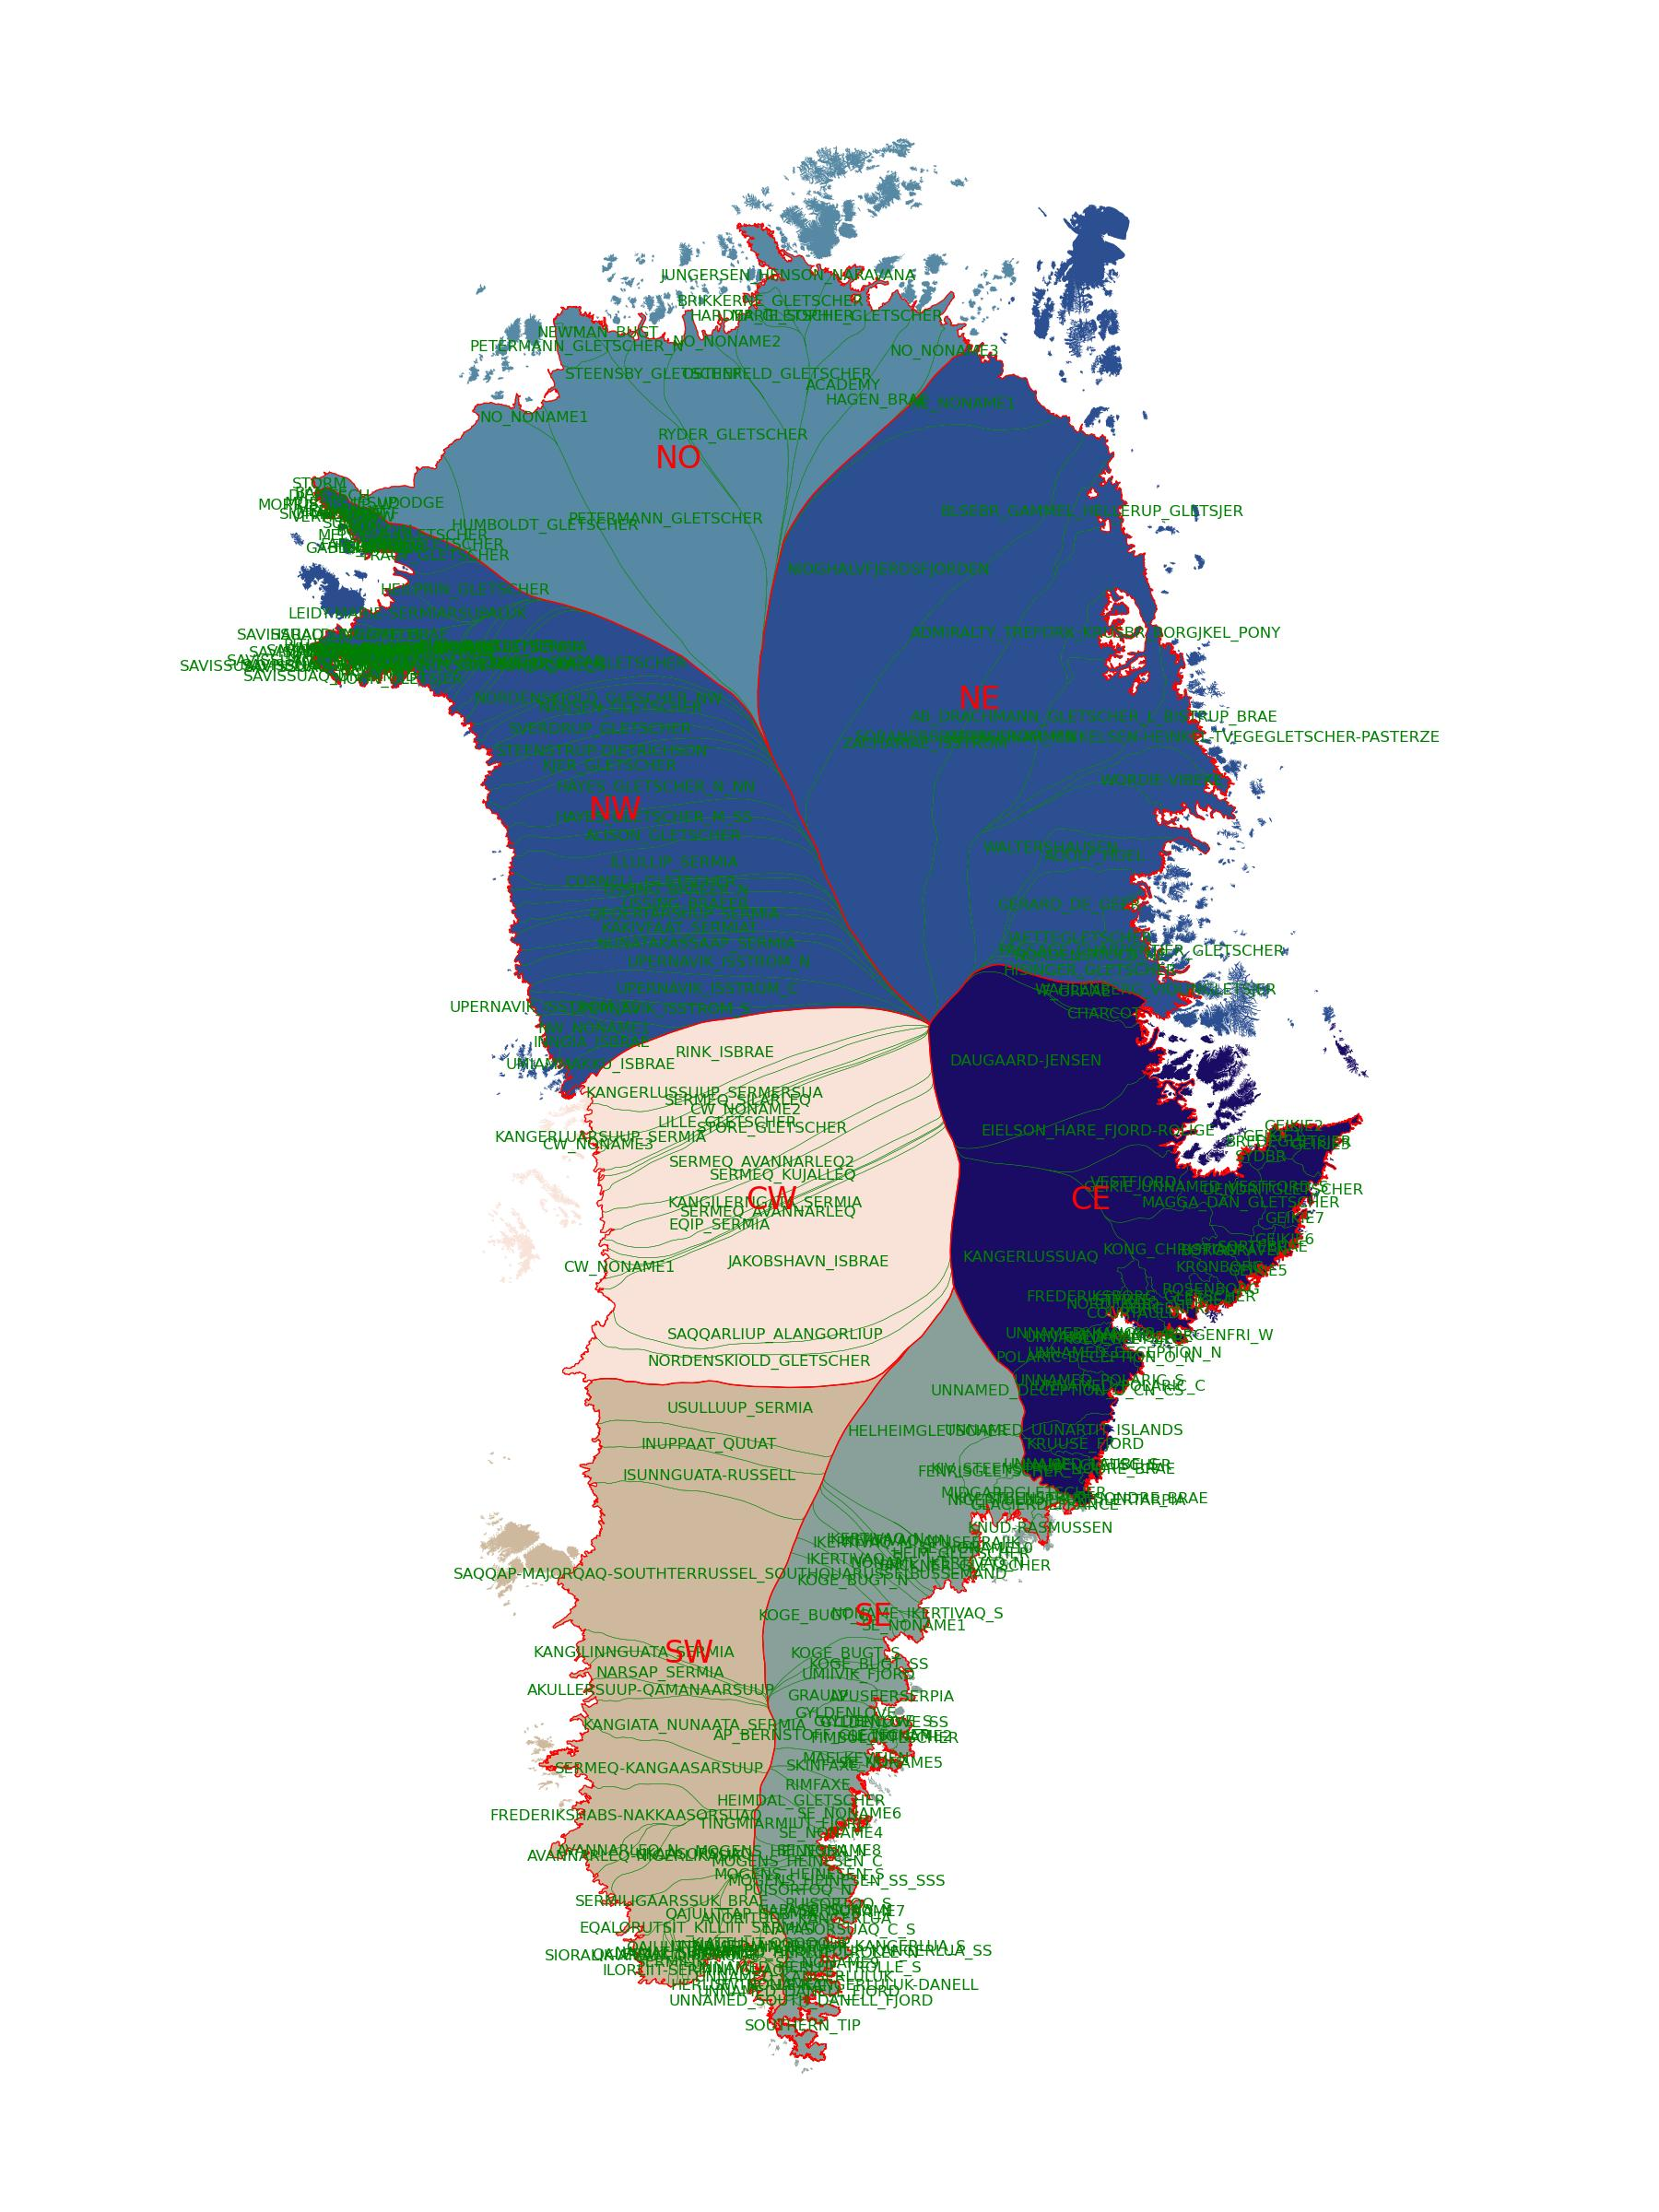

In [5]:
fig, ax = plt.subplots(figsize=[6,8])

gdf_basin.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
is_ice_cap = gdf_basin.apply(lambda x: 'ICE_CAPS' in x.NAME, axis=1)
gdf_gris = gdf_basin[~is_ice_cap].copy()
gdf_gris.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_gris.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=4),axis=1)
gdf_regions = gdf_gris.dissolve('SUBREGION1')[['geometry']].reset_index()
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)

ax.axis('off')
fig.tight_layout()

gdf_basin.head()

# show plot and print info
plotname = 'plots/input_data_Greenland.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### merge subregions and remove holes from region polygons

In [23]:
gdf_regions = gdf_gris.dissolve('SUBREGION1')[['geometry']].reset_index().set_crs(gdf_gris.crs)
def close_holes(poly):
        if poly.interiors: return Polygon(list(poly.exterior.coords))
        else: return poly
gdf_regions['geometry'] = gdf_regions.geometry.apply(lambda x: close_holes(x))
gdf_regions_copy = gdf_regions.copy()

In [24]:
gdf_regions.to_file('GRE_basins.geojson', driver="GeoJSON", crs='EPSG:3413') 
gdf_regions.to_file('shapefiles/GRE_basins_merged.shp') 

### plot the resulting data

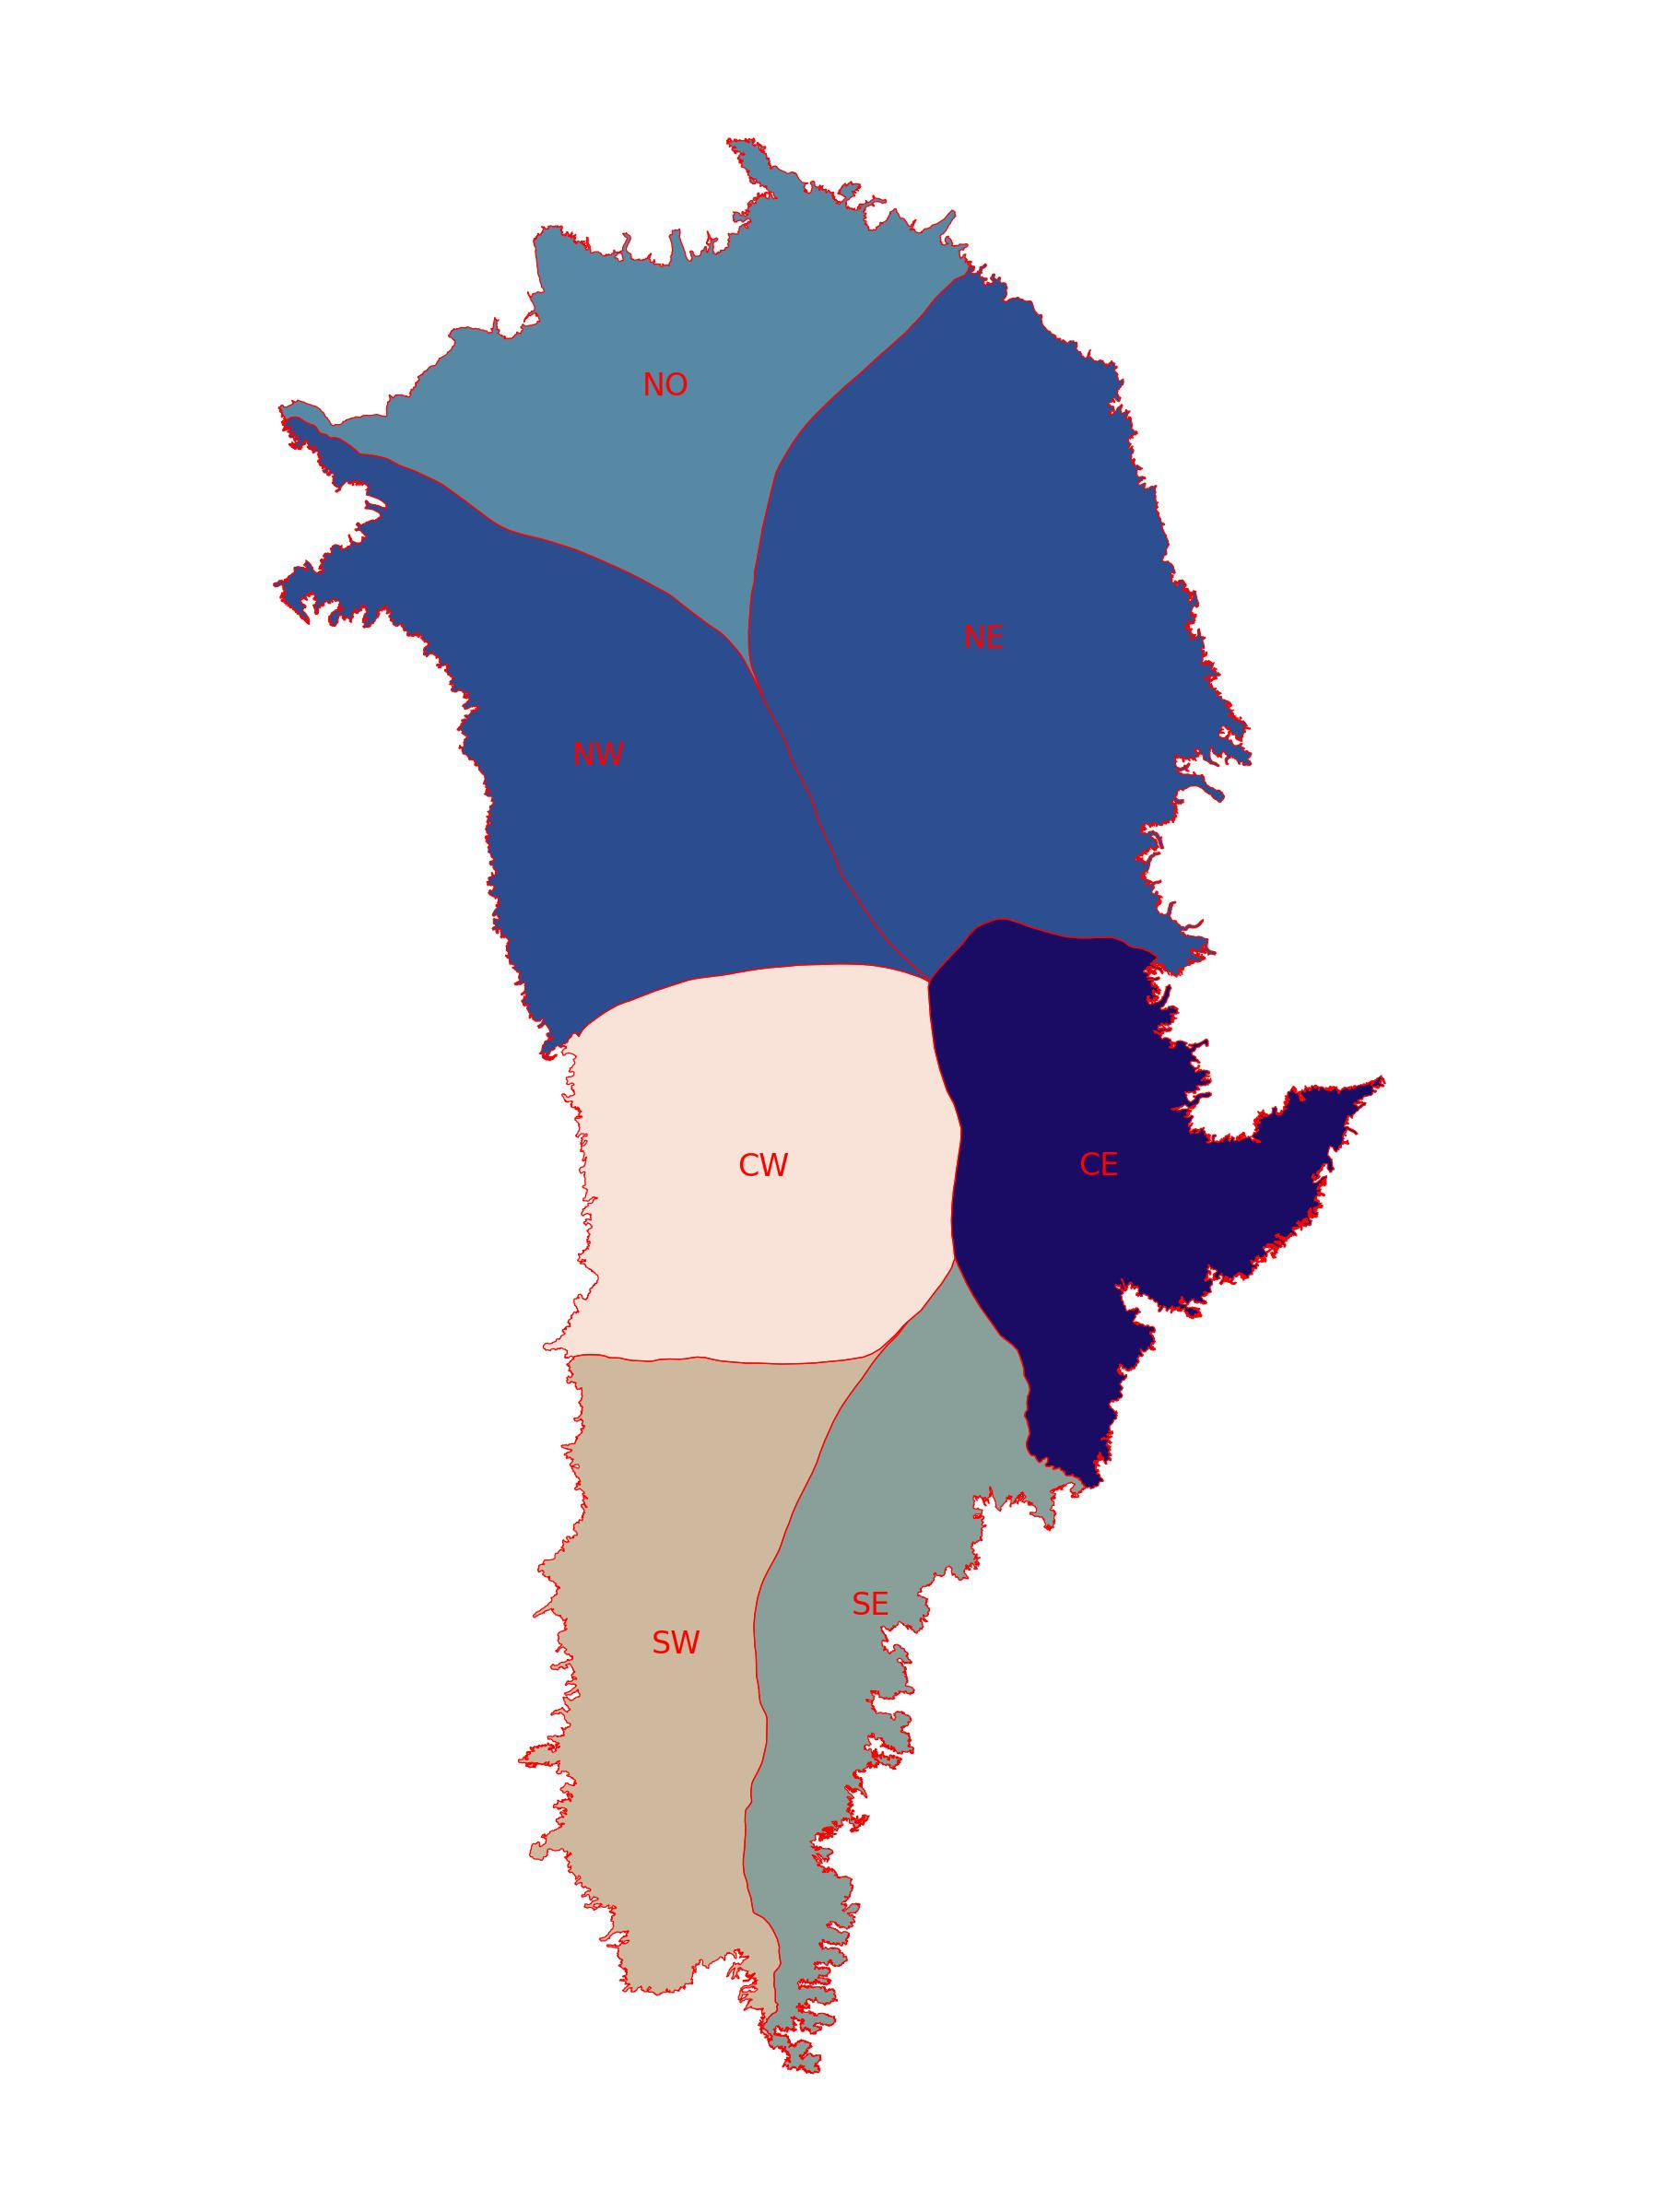

In [25]:
fig, ax = plt.subplots(figsize=[6,8])
gdf_regions.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)
ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/merged_basins_Greenland_noGRIMP.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### add the extra ice from the grimp ice mask to the IMBIE basin data
(this takes a while... / could probably be sped up but I'm tired right now)

In [26]:
mask_file = 'GRE_ice_mask/shapefiles/GimpIceMask_90m_2015_v1-2_polygon_processed.shp'
gdf_grimp = gpd.read_file(mask_file).to_crs(gdf_basin.crs)

gdf_extra = gdf_grimp.difference(gdf_regions.dissolve()).explode(index_parts=False).reset_index(drop=True)

# add each island to the subregion (including shelves) that overlaps most with the island's boundary
for i,geom in enumerate(gdf_extra):
    print('%6i / %6i' % (i+1, len(gdf_extra)), end='\r')
    r = gdf_regions[gdf_regions.boundary.intersects(geom.boundary)]
    if len(r) > 0:
        if len(r) > 1:
            r = r.iloc[r.intersection(geom.boundary).length.argmax()]
        else:
            r = r.iloc[0]
        gdf_regions.loc[len(gdf_regions)] = [r.SUBREGION1, geom]
        
gdf_merged = gdf_regions.dissolve('SUBREGION1').explode(index_parts=False).copy().set_crs(gdf_gris.crs).reset_index(drop=False)

## make subregion lookup table including GRIMP for lake subregion assignment

In [83]:
import pandas as pd
mask_file = 'GRE_ice_mask/shapefiles/GimpIceMask_90m_2015_v1-2_polygon_processed.shp'
gdf_grimp = gpd.read_file(mask_file).to_crs(gdf_basin.crs)
fn = 'shapefiles/Greenland_Basins_PS_v1.4.2.shp'
gdf_basin = gpd.read_file(fn)
is_ice_cap = gdf_basin.apply(lambda x: 'ICE_CAPS' in x.NAME, axis=1)
gdf_gris_ = gdf_basin[~is_ice_cap].copy()
gdf_gris_['geometry'] = gdf_basin.geometry.buffer(50)

In [84]:
def close_holes(poly):
        if poly.interiors: return Polygon(list(poly.exterior.coords))
        else: return poly
gdf_gris_['geometry'] = gdf_gris_.geometry.apply(lambda x: close_holes(x))

gdf_extra_ = gdf_grimp.difference(gdf_gris_.dissolve()).explode(index_parts=False).reset_index(drop=True)

 12800 /  12869 extra polygons merged...

-->  1764 do not border IMBIE
--> 11009 border one named IMBIE basin
-->    96 border multiple named basins

...dissolving
...merging multipolygons

saving files for final GIMP-ice-mask-expanded collection with full names for each region
plotting results...


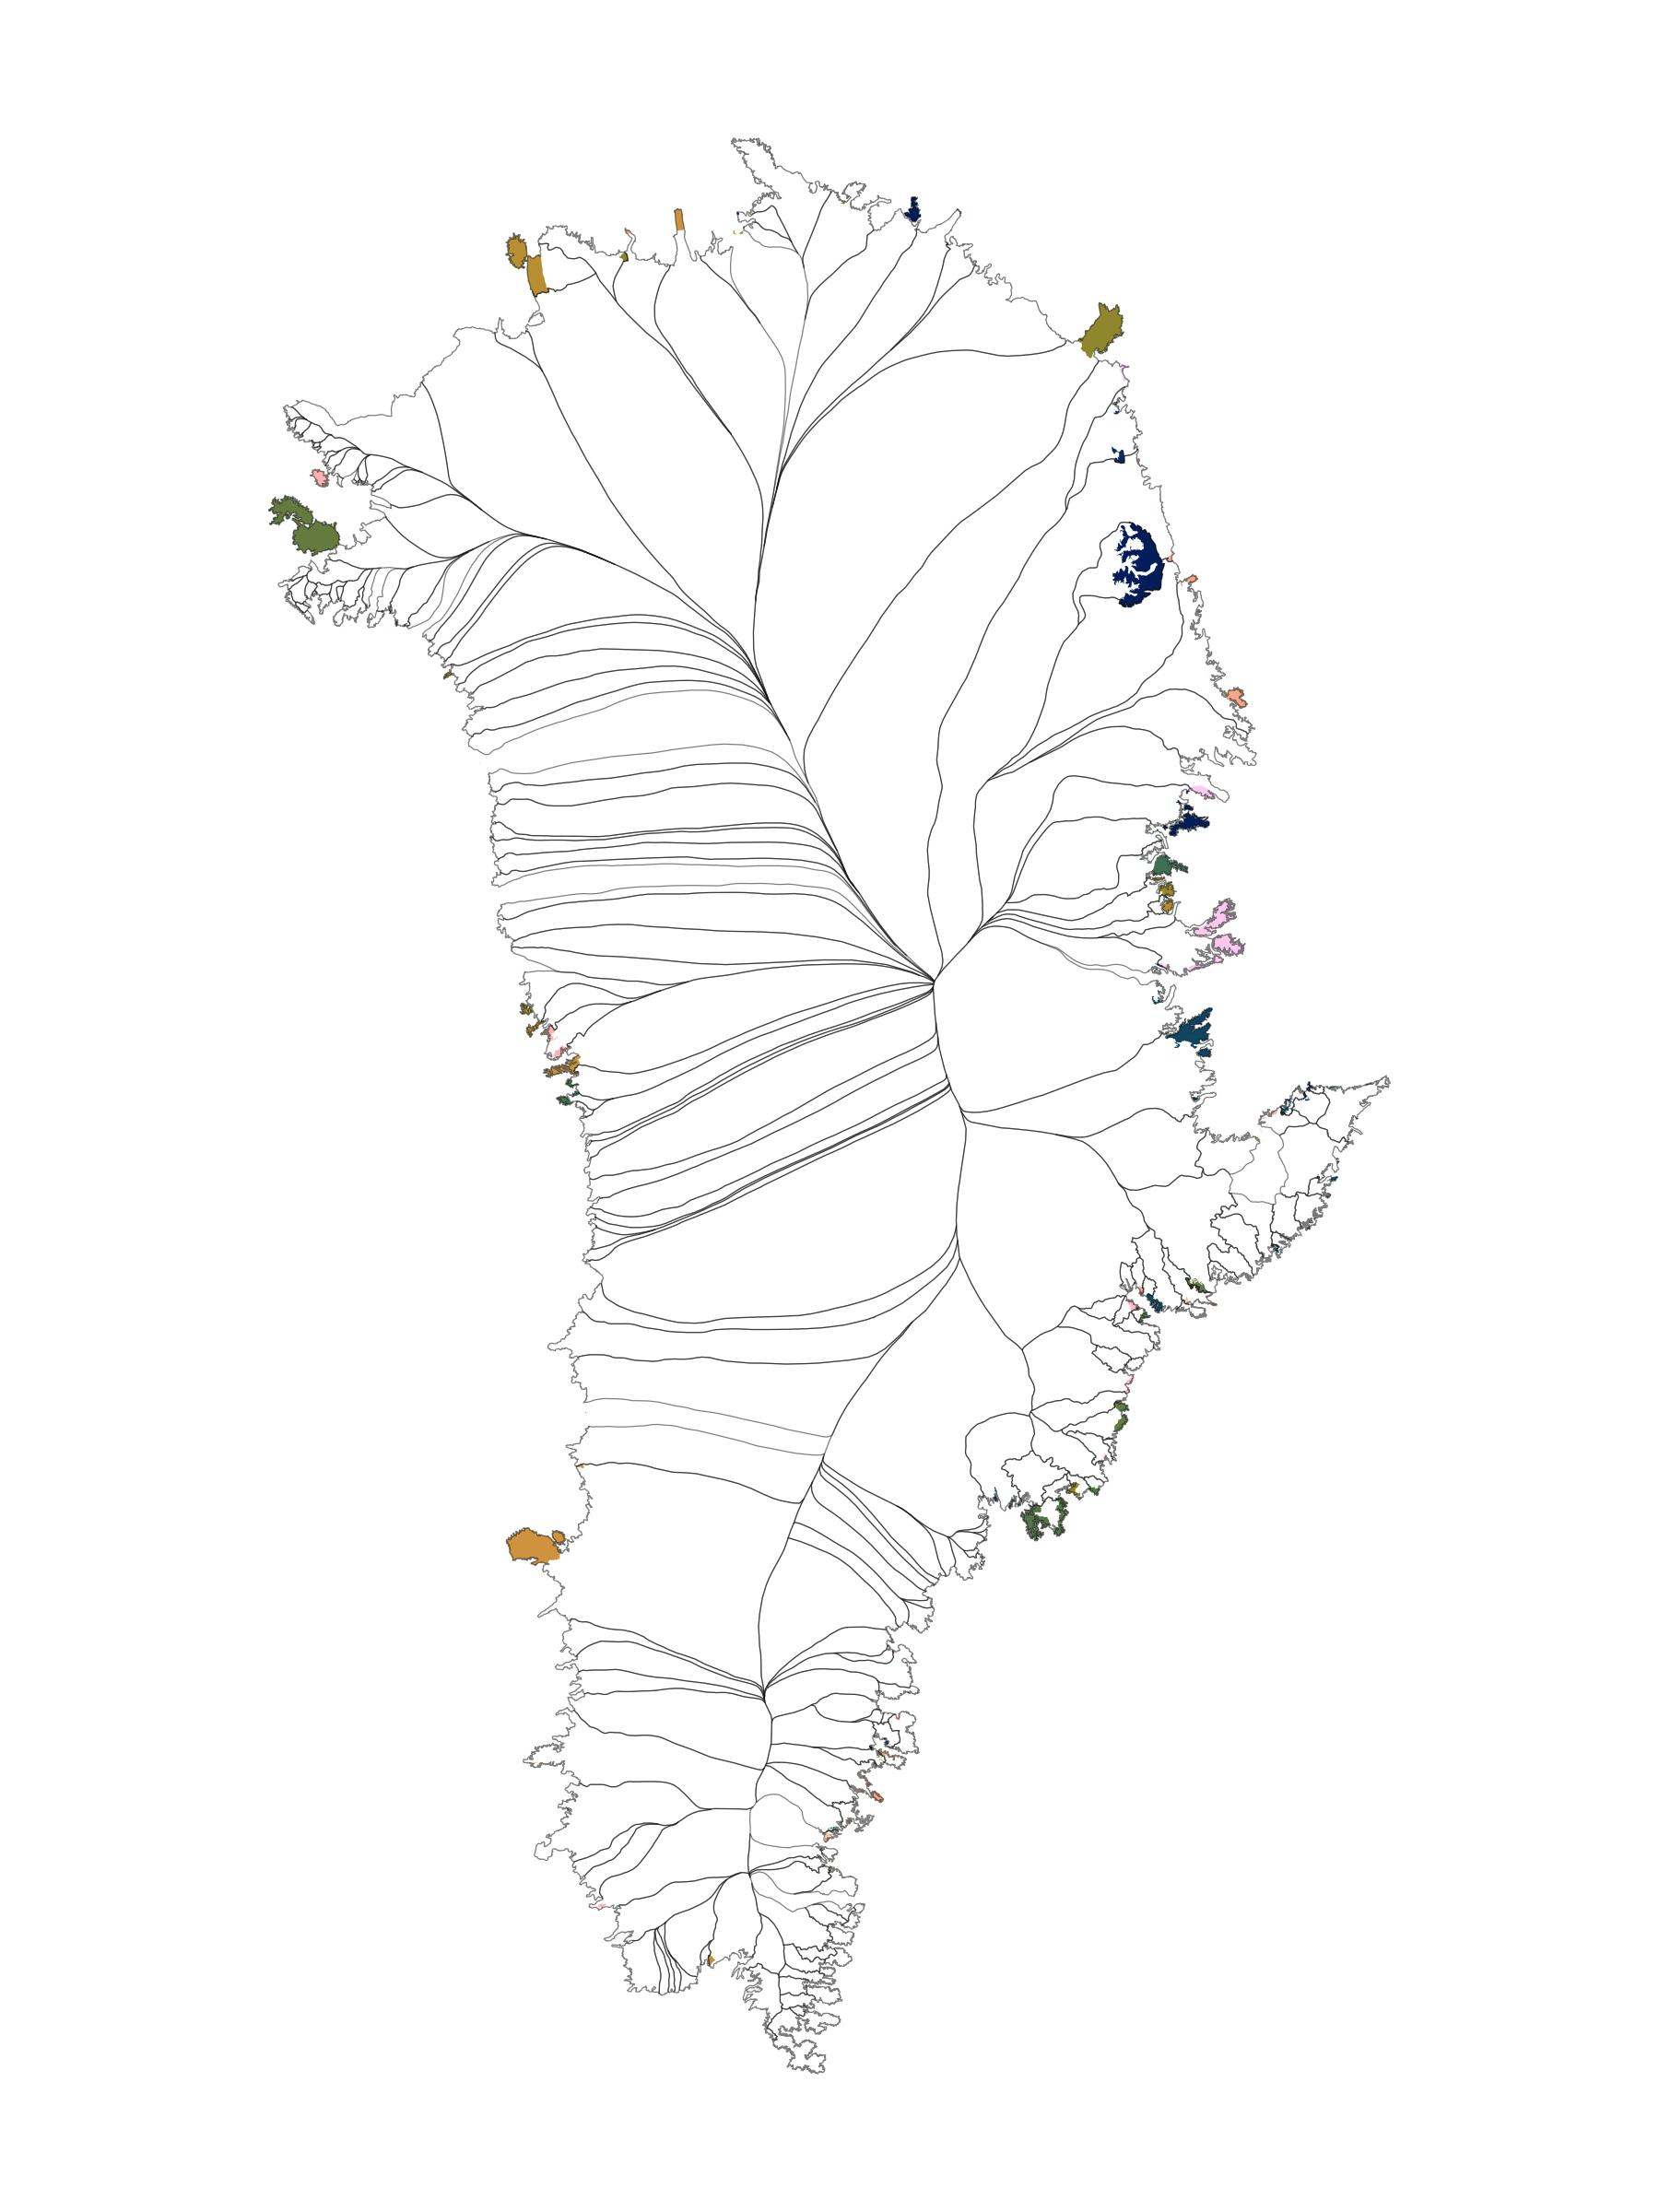

In [134]:
# add each extra part to the NAME region that overlaps most with its boundary
intersect_1 = 0
no_intersect = 0
intersect_multiple = 0
assign_list = []
for i,geom in enumerate(gdf_extra_):
    if (i+1)%100==0:
        print('%6i / %6i extra polygons merged...' % (i+1, len(gdf_extra_)), end='\r')
    r = gdf_gris_[gdf_gris_.boundary.intersects(geom.boundary)].copy()
    if len(r) > 0:
        if len(r) > 1:
            r = r.loc[[r.intersection(geom.boundary).length.idxmax()]].copy()
            intersect_multiple += 1
        else:
            intersect_1 += 1
        r['geometry'] = geom
        assign_list.append(r)
    else:
        no_intersect +=1

print('\n\n--> %5i do not border IMBIE' % no_intersect)
print('--> %5i border one named IMBIE basin' % intersect_1)
print('--> %5i border multiple named basins' % intersect_multiple)

print('\n...dissolving')
temp = pd.concat([gdf_gris_] + assign_list).dissolve('NAME').reset_index()
print('...merging multipolygons')
temp['geometry'] = temp.apply(merge_multipolygons, axis=1).set_crs(gdf_gris_.crs)

print('\nsaving files for final GIMP-ice-mask-expanded collection with full names for each region')
gdf_names = temp.copy()
gdf_names.to_file('GRE_fullnames_GIMP_merged.geojson', driver="GeoJSON", crs='EPSG:3413') 
gdf_names.to_file('shapefiles/GRE_fullnames_GIMP_merged.shp') 

print('plotting results...')
temp2 = pd.concat( assign_list)
fig, ax = plt.subplots(figsize=[6,8])
temp2.plot(ax=ax, column='NAME', cmap=cmc.batlow, lw=0.3)
temp.exterior.plot(ax=ax, color='k', lw=0.3, alpha=0.5)

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/GRE_fullnames_GIMP_additions.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

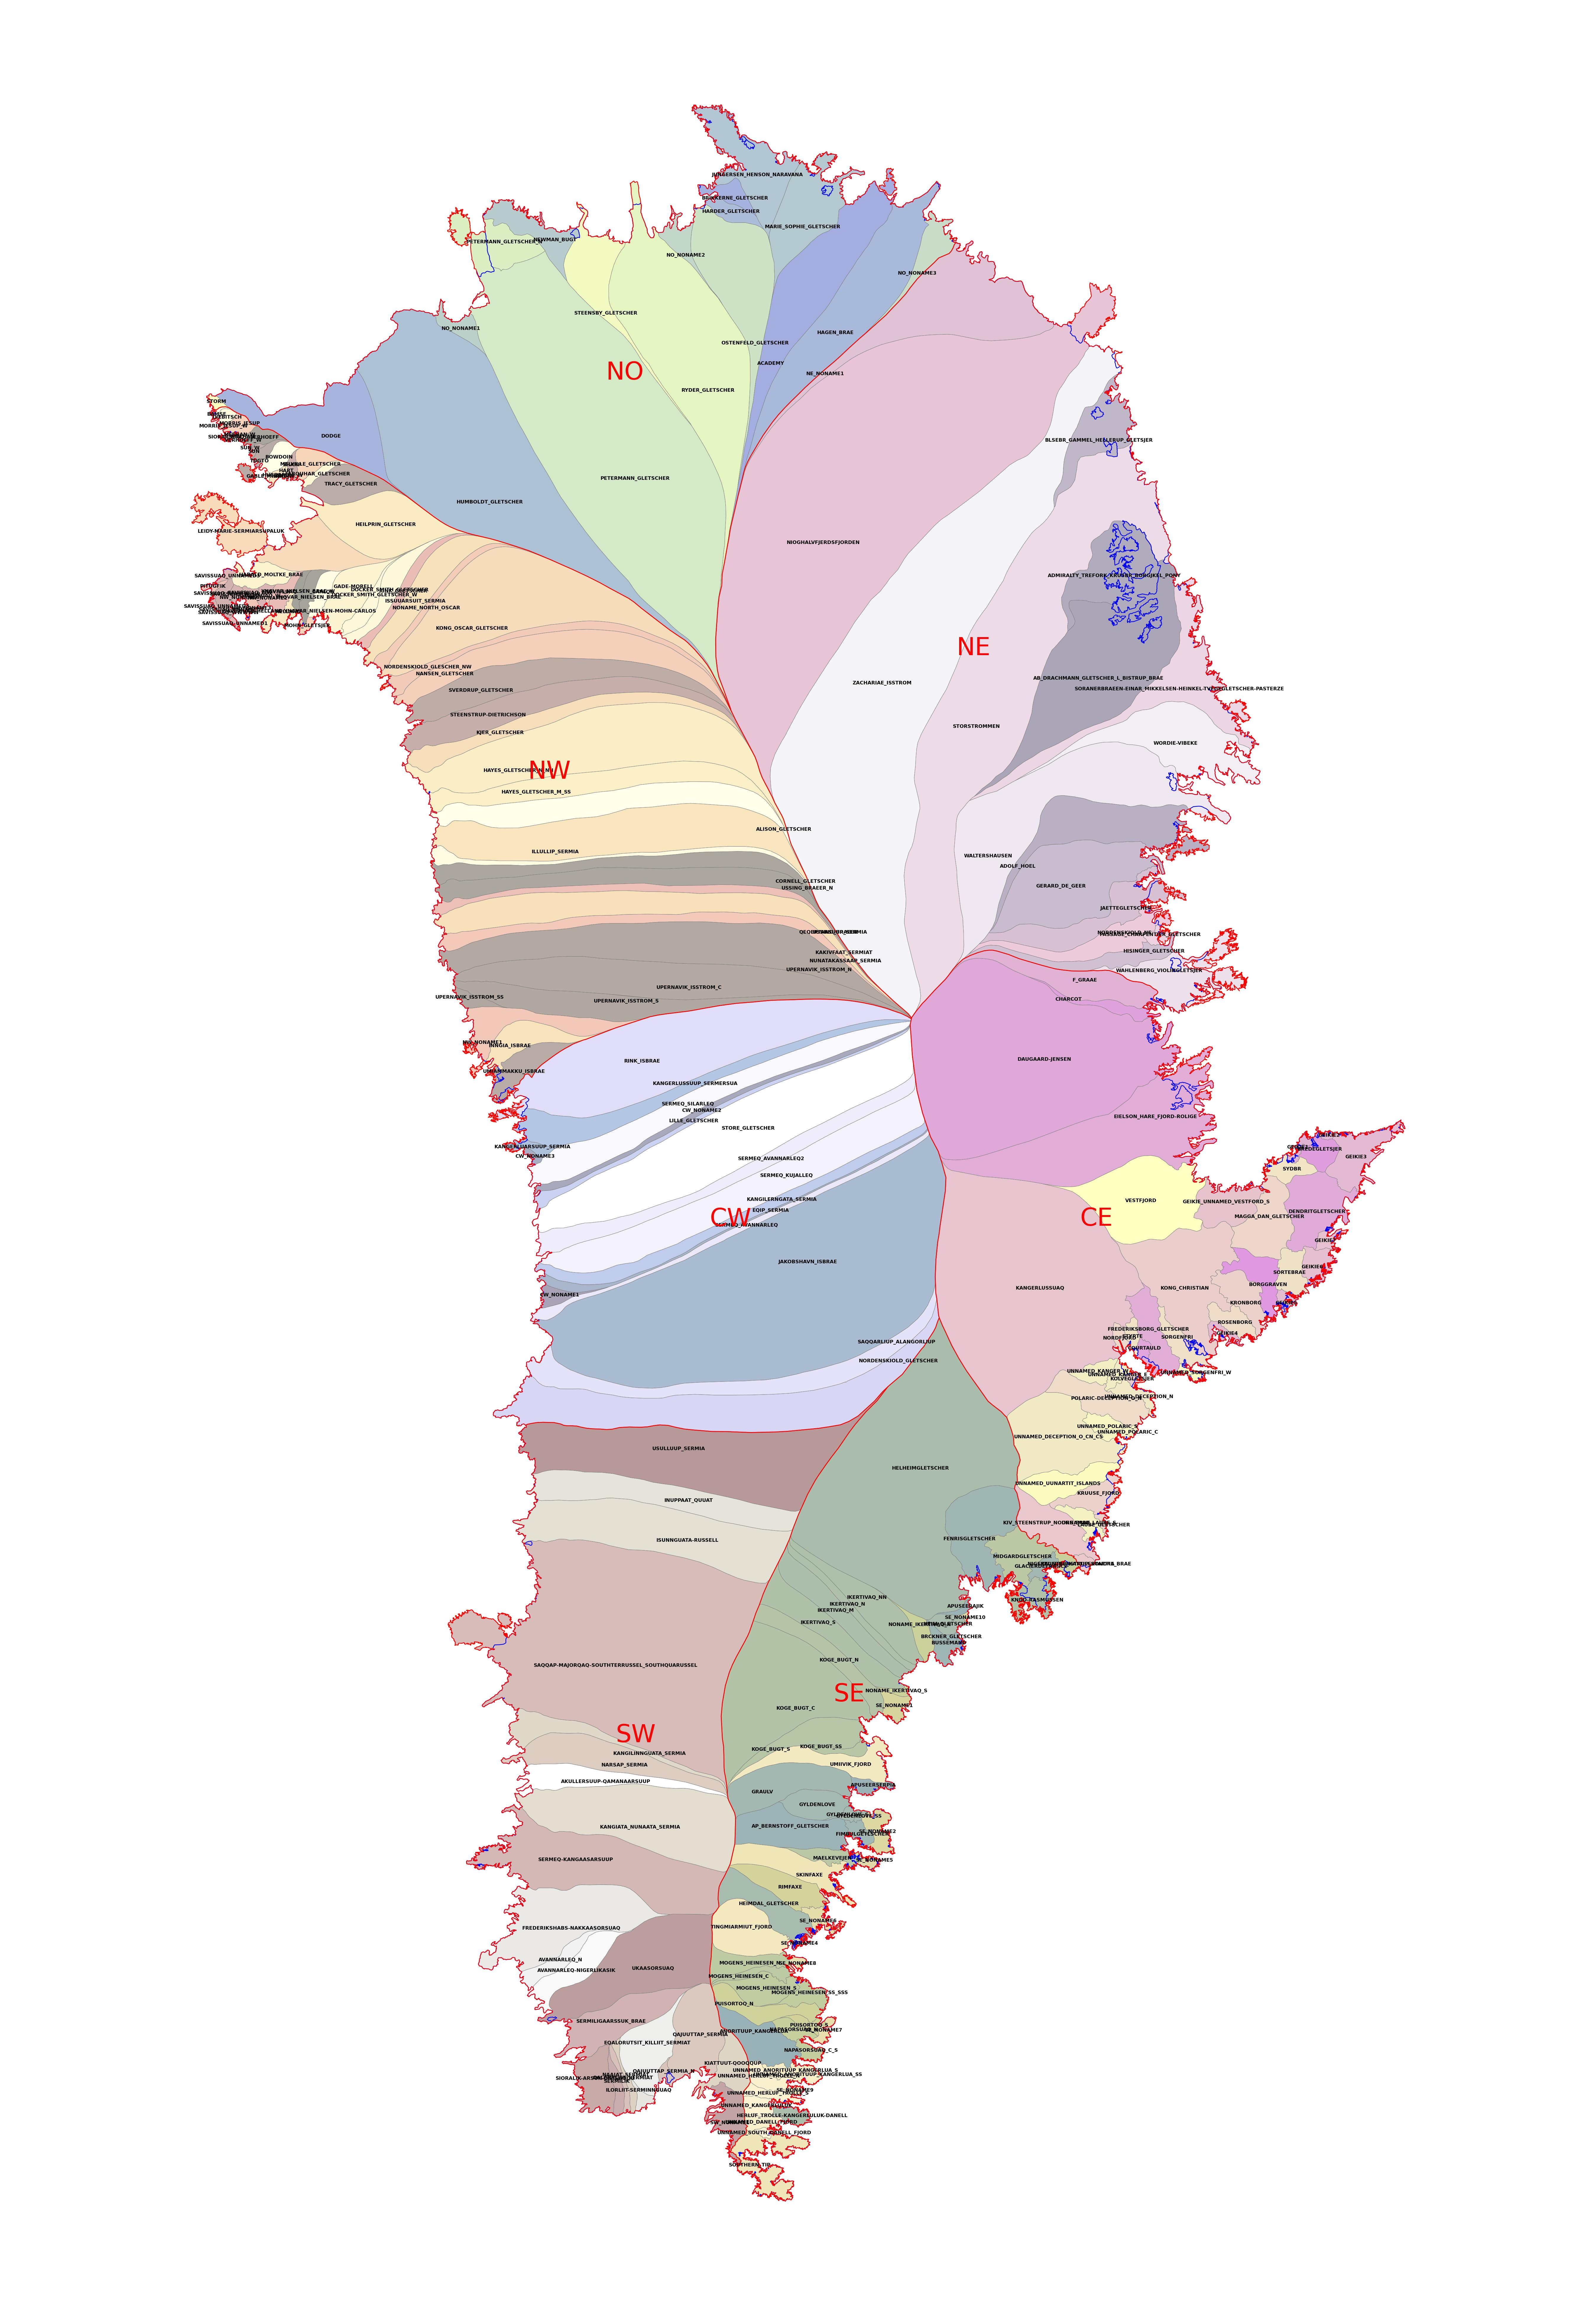

In [153]:
gdf_names = gpd.read_file('shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_merged = gpd.read_file('shapefiles/GRE_basins_merged_GRIMP.shp') 

fig, ax = plt.subplots(figsize=[9,13])

regcms = {
    'NO': cmc.imola,
    'NW': cmc.lajolla,
    'NE': cmc.acton, 
    'CW': cmc.devon,
    'CE': cmc.buda,
    'SW': cmc.bilbao,
    'SE': cmc.bamako
}
for i, sub in enumerate(np.unique(gdf_names.SUBREGION1)):
    gdf_sub = gdf_names[gdf_names.SUBREGION1 == sub]
    gdf_sub.plot(column='NAME', cmap=regcms[sub], ax=ax, alpha=0.4)
    
gdf_names.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_names.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.representative_point().coords[0], 
                ha='center',va='center', color='k', fontsize=2, fontweight='bold'), axis=1)
gdf_imbiemargins = gdf_gris.dissolve()[['geometry']].reset_index().set_crs(gdf_gris.crs)
gdf_imbiemargins.boundary.plot(color='b', ax=ax, lw=0.3)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_merged.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], 
                                       ha='center',va='center',color='r',fontsize=10),axis=1)

ax.axis('off')
fig.tight_layout(pad=0)

# show plot and print info
plotname = 'plots/GRE_fullnames_GIMP_merged.jpg'
fig.savefig(plotname , dpi=600)
plt.close(fig)
display(Image(plotname))

## plot main basins only

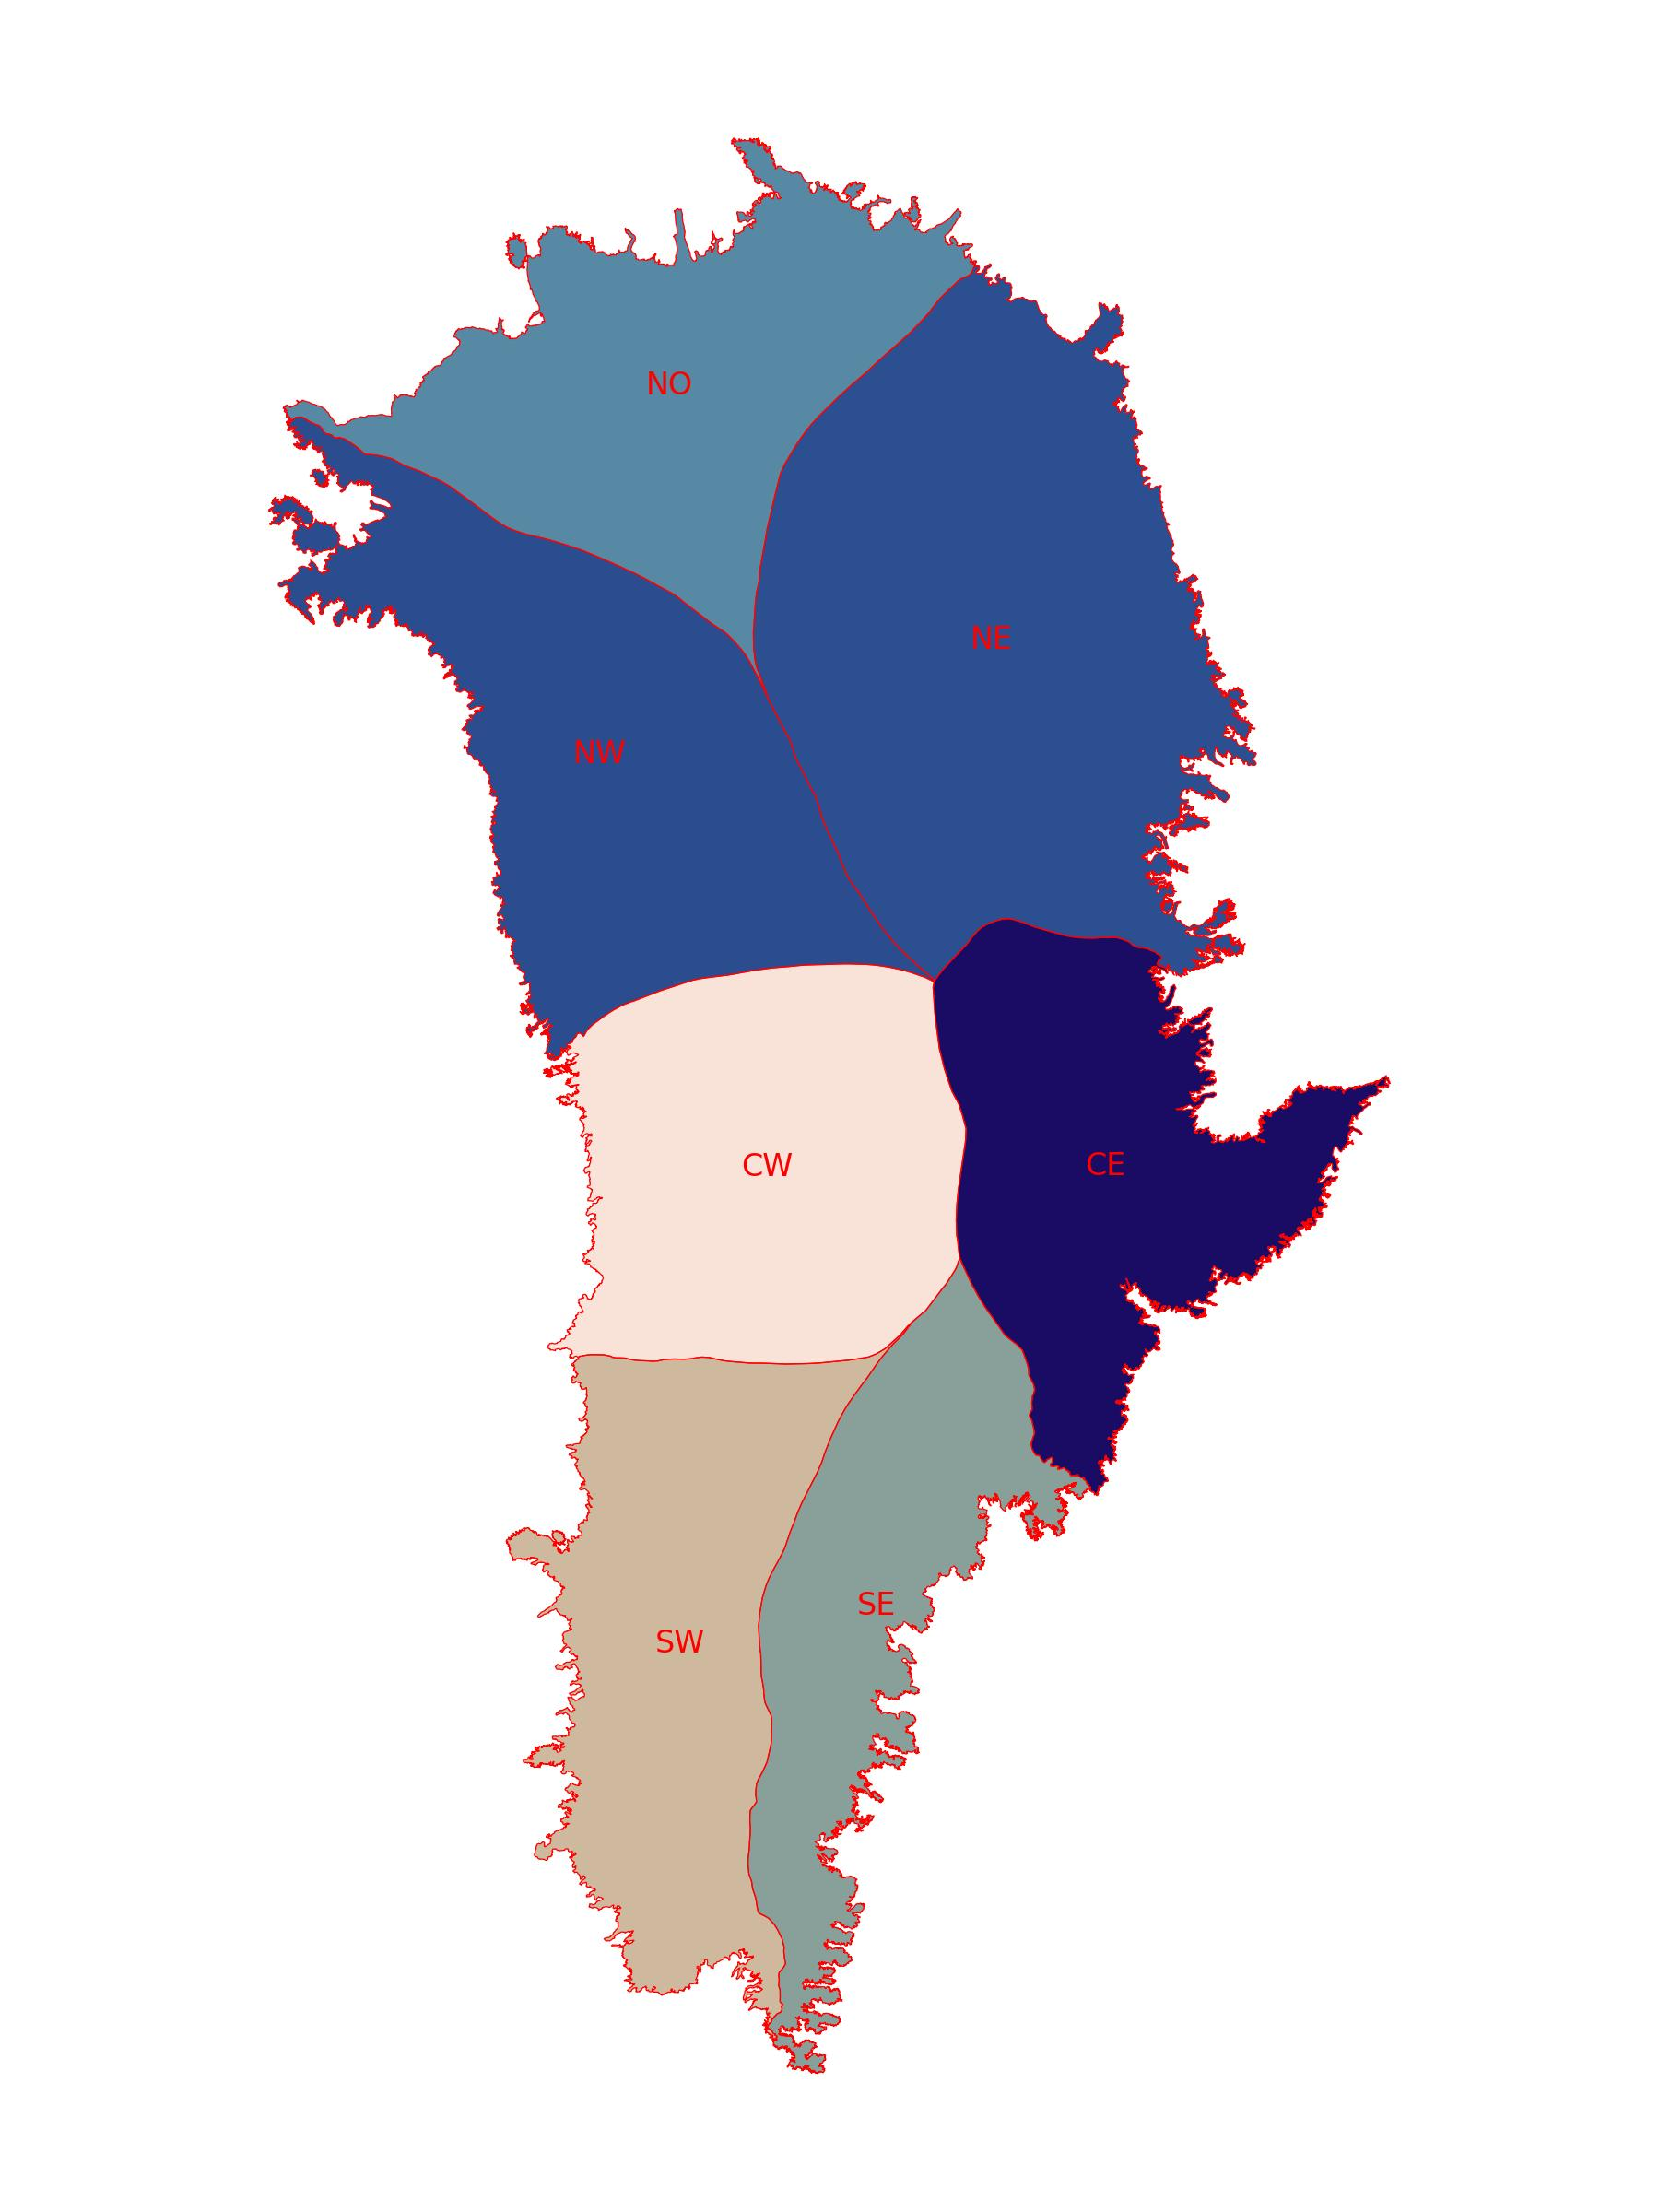

In [138]:
fig, ax = plt.subplots(figsize=[6,8])
gdf_merged.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
# gdf_regions_copy.boundary.plot(color='b', ax=ax, lw=0.3)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_merged.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)
ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/merged_basins_Greenland_withGRIMP.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

In [28]:
gdf_merged.to_file('GRE_basins_GRIMP.geojson', driver="GeoJSON", crs='EPSG:3413') 
gdf_merged.to_file('shapefiles/GRE_basins_merged_GRIMP.shp') 

### Threshold by elevation

Use ~2000m based on this: https://www.sciencedirect.com/science/article/pii/S0034425723003322
- Zhang, W., Yang, K., Smith, L. C., Wang, Y., van As, D., Noël, B., ... & Liu, J. (2023). Pan-Greenland mapping of supraglacial rivers, lakes, and water-filled crevasses in a cool summer (2018) and a warm summer (2019). Remote Sensing of Environment, 297, 113781.

In [29]:
elevation_threshold = 2200
coast_buffer = 1000
fn_dem = 'DEMs/arcticdem_mosaic_1km_v4.1_dem.tif'

def threshold_geotiff_to_geodataframe(input_path, threshold):
    with rio.open(input_path) as src:
        profile = src.profile
        data = src.read(1)  # Read the first band
        thresholded_data = data < threshold
        mask = thresholded_data.astype('uint8')
        shapes = features.shapes(mask, transform=src.transform)
        polygons = []
        for geom, value in shapes:
            if value == 1:
                polygons.append(shape(geom))
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile['crs']).dissolve()[['geometry']].reset_index(drop=True)
        gdf['geometry'] = gdf.geometry.simplify(src.res[0], preserve_topology=True)
        return gdf

gdf_dem = threshold_geotiff_to_geodataframe(fn_dem, elevation_threshold)
gdf_thresh = gdf_merged.copy()
gdf_thresh['geometry'] = gdf_thresh.intersection(gdf_dem.iloc[0].geometry)
gdf_coast = gdf_merged.dissolve()
boundary = gdf_merged.intersection(gdf_coast.iloc[0].geometry.boundary.buffer(coast_buffer))
gdf_thresh['geometry'] = gdf_thresh.union(boundary)

def fill_holes(x):
    if x.geometry.geom_type == 'Polygon':
        poly = x.geometry
        if poly.interiors: 
            return Polygon(list(poly.exterior.coords))
        else: 
            return poly
    if x.geometry.geom_type == 'MultiPolygon':
        for poly in x.geometry.geoms:
            if poly.interiors: 
                poly_filled = Polygon(list(poly.exterior.coords))
            else: 
                poly_filled = poly
            if poly_filled.intersects(gdf_coast.boundary.geometry.iloc[0]):
                return poly_filled
        
gdf_thresh['geometry'] = gdf_thresh.apply(fill_holes, axis=1)

In [30]:
gdf_thresh.to_file('GRE_basins_thresh%i.geojson' % elevation_threshold , driver="GeoJSON", crs='EPSG:3413') 
gdf_thresh.to_file('shapefiles/GRE_basins_thresh%i.shp' % elevation_threshold) 

### plot the final regions

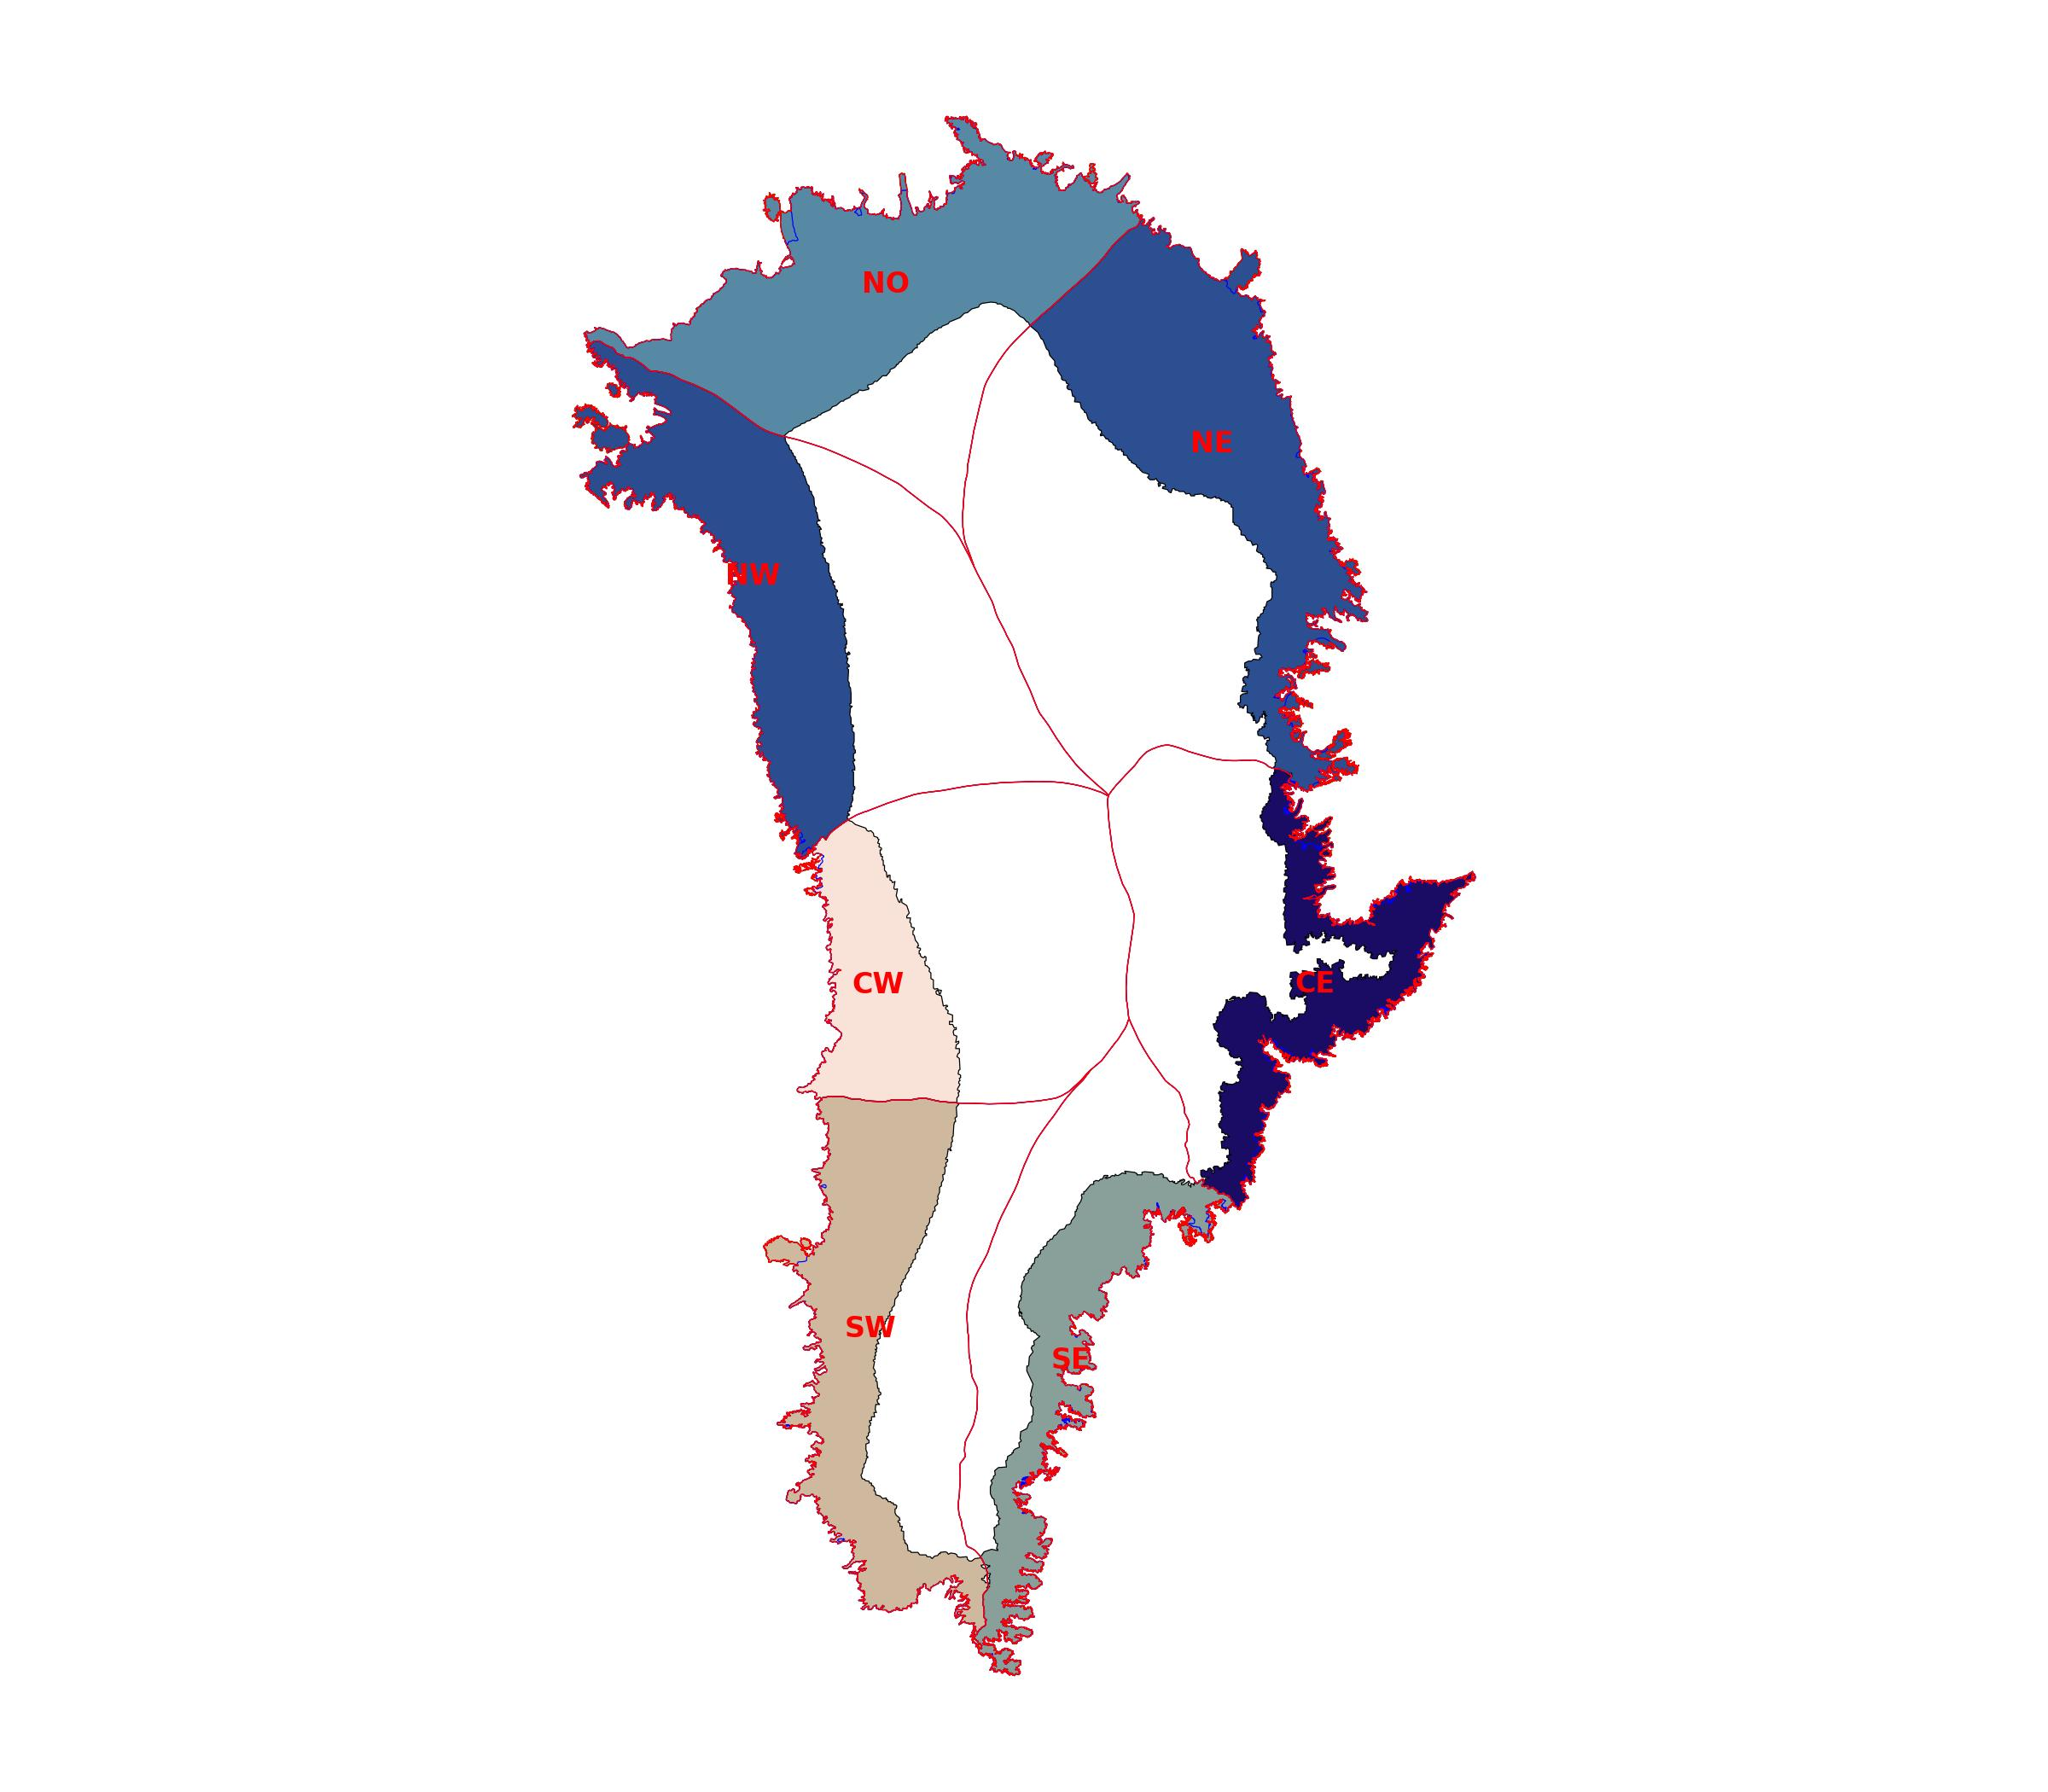

In [31]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_regions_copy.boundary.plot(color='b', ax=ax, lw=0.3)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/thresholded_basins_Greenland.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

In [32]:
simplify_tol = 10000 # 10 km 
gdf_thresh_simple = gdf_thresh.copy()
gdf_thresh['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=False), sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh_simple.apply(fill_holes, axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh_simple.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)

gre_gdf_thresh = gdf_thresh.copy()
gre_gdf_thresh_simple = gdf_thresh_simple.copy()
gre_gdf_regions = gdf_regions_copy.copy()
gre_gdf_merged = gdf_merged.copy()

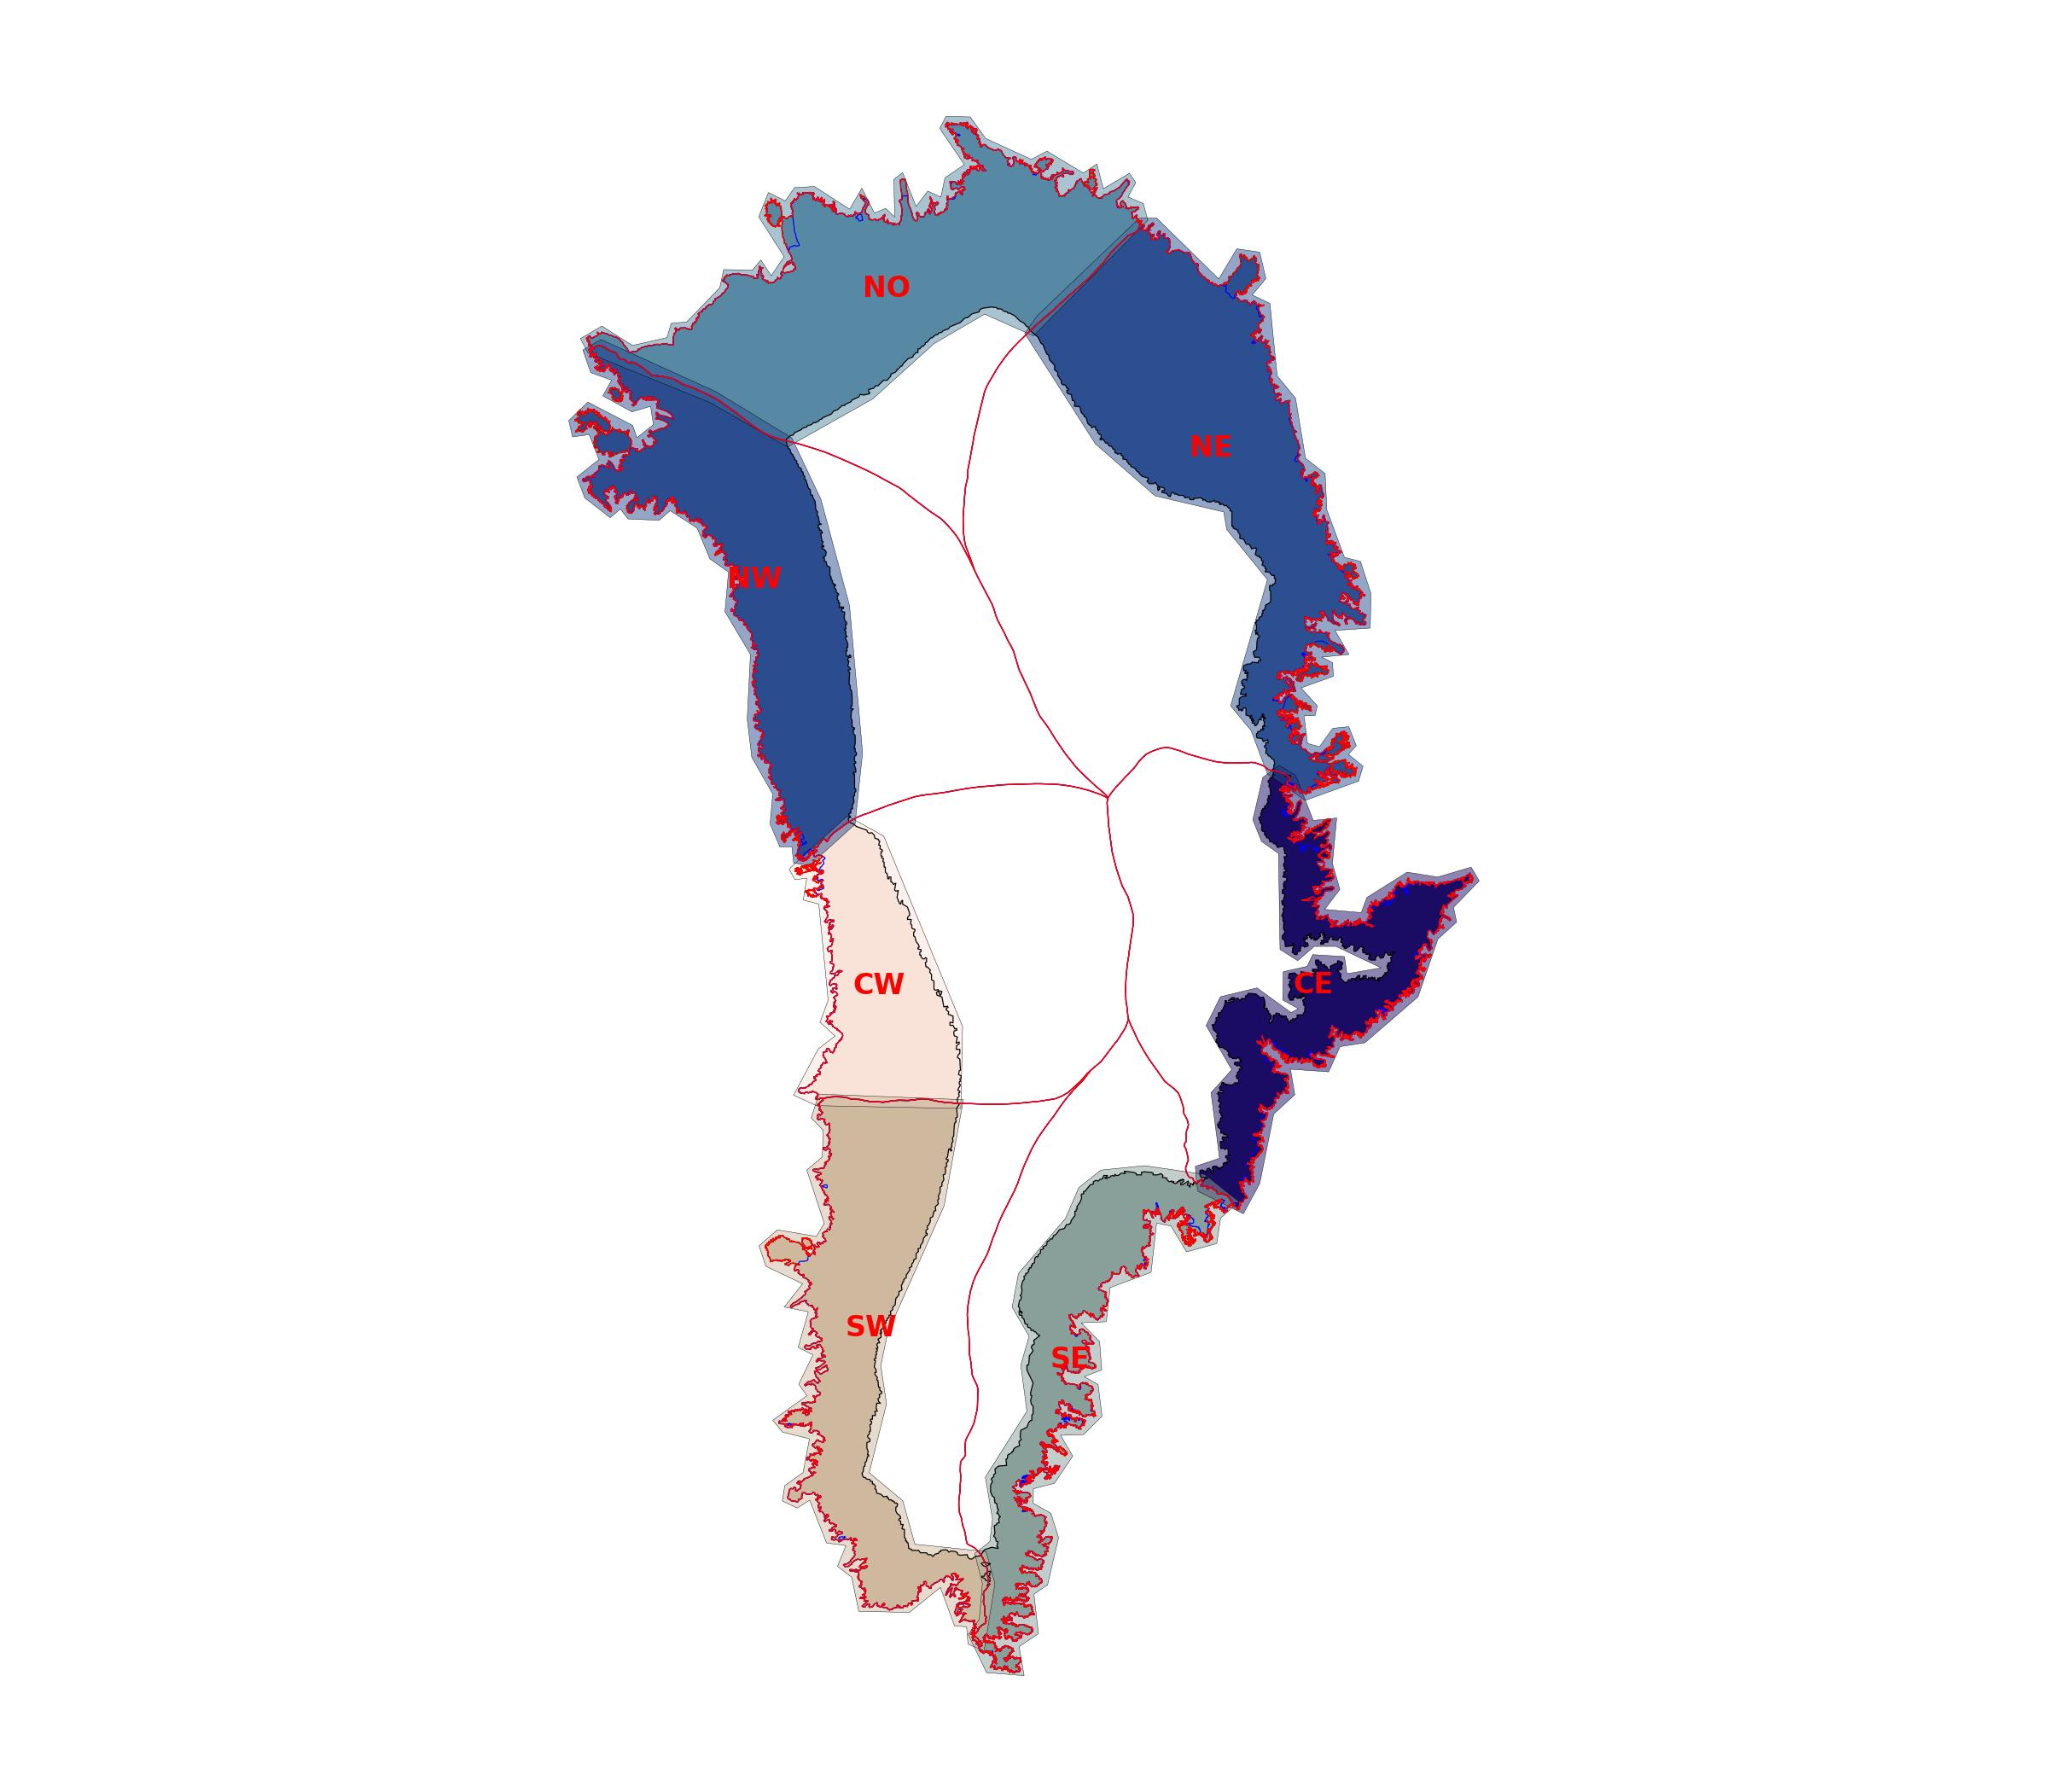

In [33]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_thresh_simple.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax, alpha=0.5)
gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_regions_copy.boundary.plot(color='b', ax=ax, lw=0.3)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

# show plot and print info
plotname = 'plots/thresholded_basins_Greenland_NSIDC_simplified.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

### Write polygons to geojson files for NSIDC queries

In [34]:
for i in range(len(gre_gdf_thresh)):
    row = gre_gdf_thresh.iloc[i]

    # write full polygon
    poly = orient(row.geometry, sign=1.0)
    out_fn = '../geojsons/GRE_%i_%s.geojson' % (elevation_threshold, row.SUBREGION1)
    gpd.GeoSeries(poly).set_crs(gre_gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

    poly = orient(row.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0)
    out_fn = '../geojsons/simplified_GRE_%i_%s.geojson' % (elevation_threshold, row.SUBREGION1)
    gpd.GeoSeries(poly).set_crs(gre_gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

Wrote file: ../geojsons/GRE_2200_CE.geojson
Wrote file: ../geojsons/simplified_GRE_2200_CE.geojson
Wrote file: ../geojsons/GRE_2200_CW.geojson
Wrote file: ../geojsons/simplified_GRE_2200_CW.geojson
Wrote file: ../geojsons/GRE_2200_NE.geojson
Wrote file: ../geojsons/simplified_GRE_2200_NE.geojson
Wrote file: ../geojsons/GRE_2200_NO.geojson
Wrote file: ../geojsons/simplified_GRE_2200_NO.geojson
Wrote file: ../geojsons/GRE_2200_NW.geojson
Wrote file: ../geojsons/simplified_GRE_2200_NW.geojson
Wrote file: ../geojsons/GRE_2200_SE.geojson
Wrote file: ../geojsons/simplified_GRE_2200_SE.geojson
Wrote file: ../geojsons/GRE_2200_SW.geojson
Wrote file: ../geojsons/simplified_GRE_2200_SW.geojson


# make plots of the resulting basins for both ice sheets

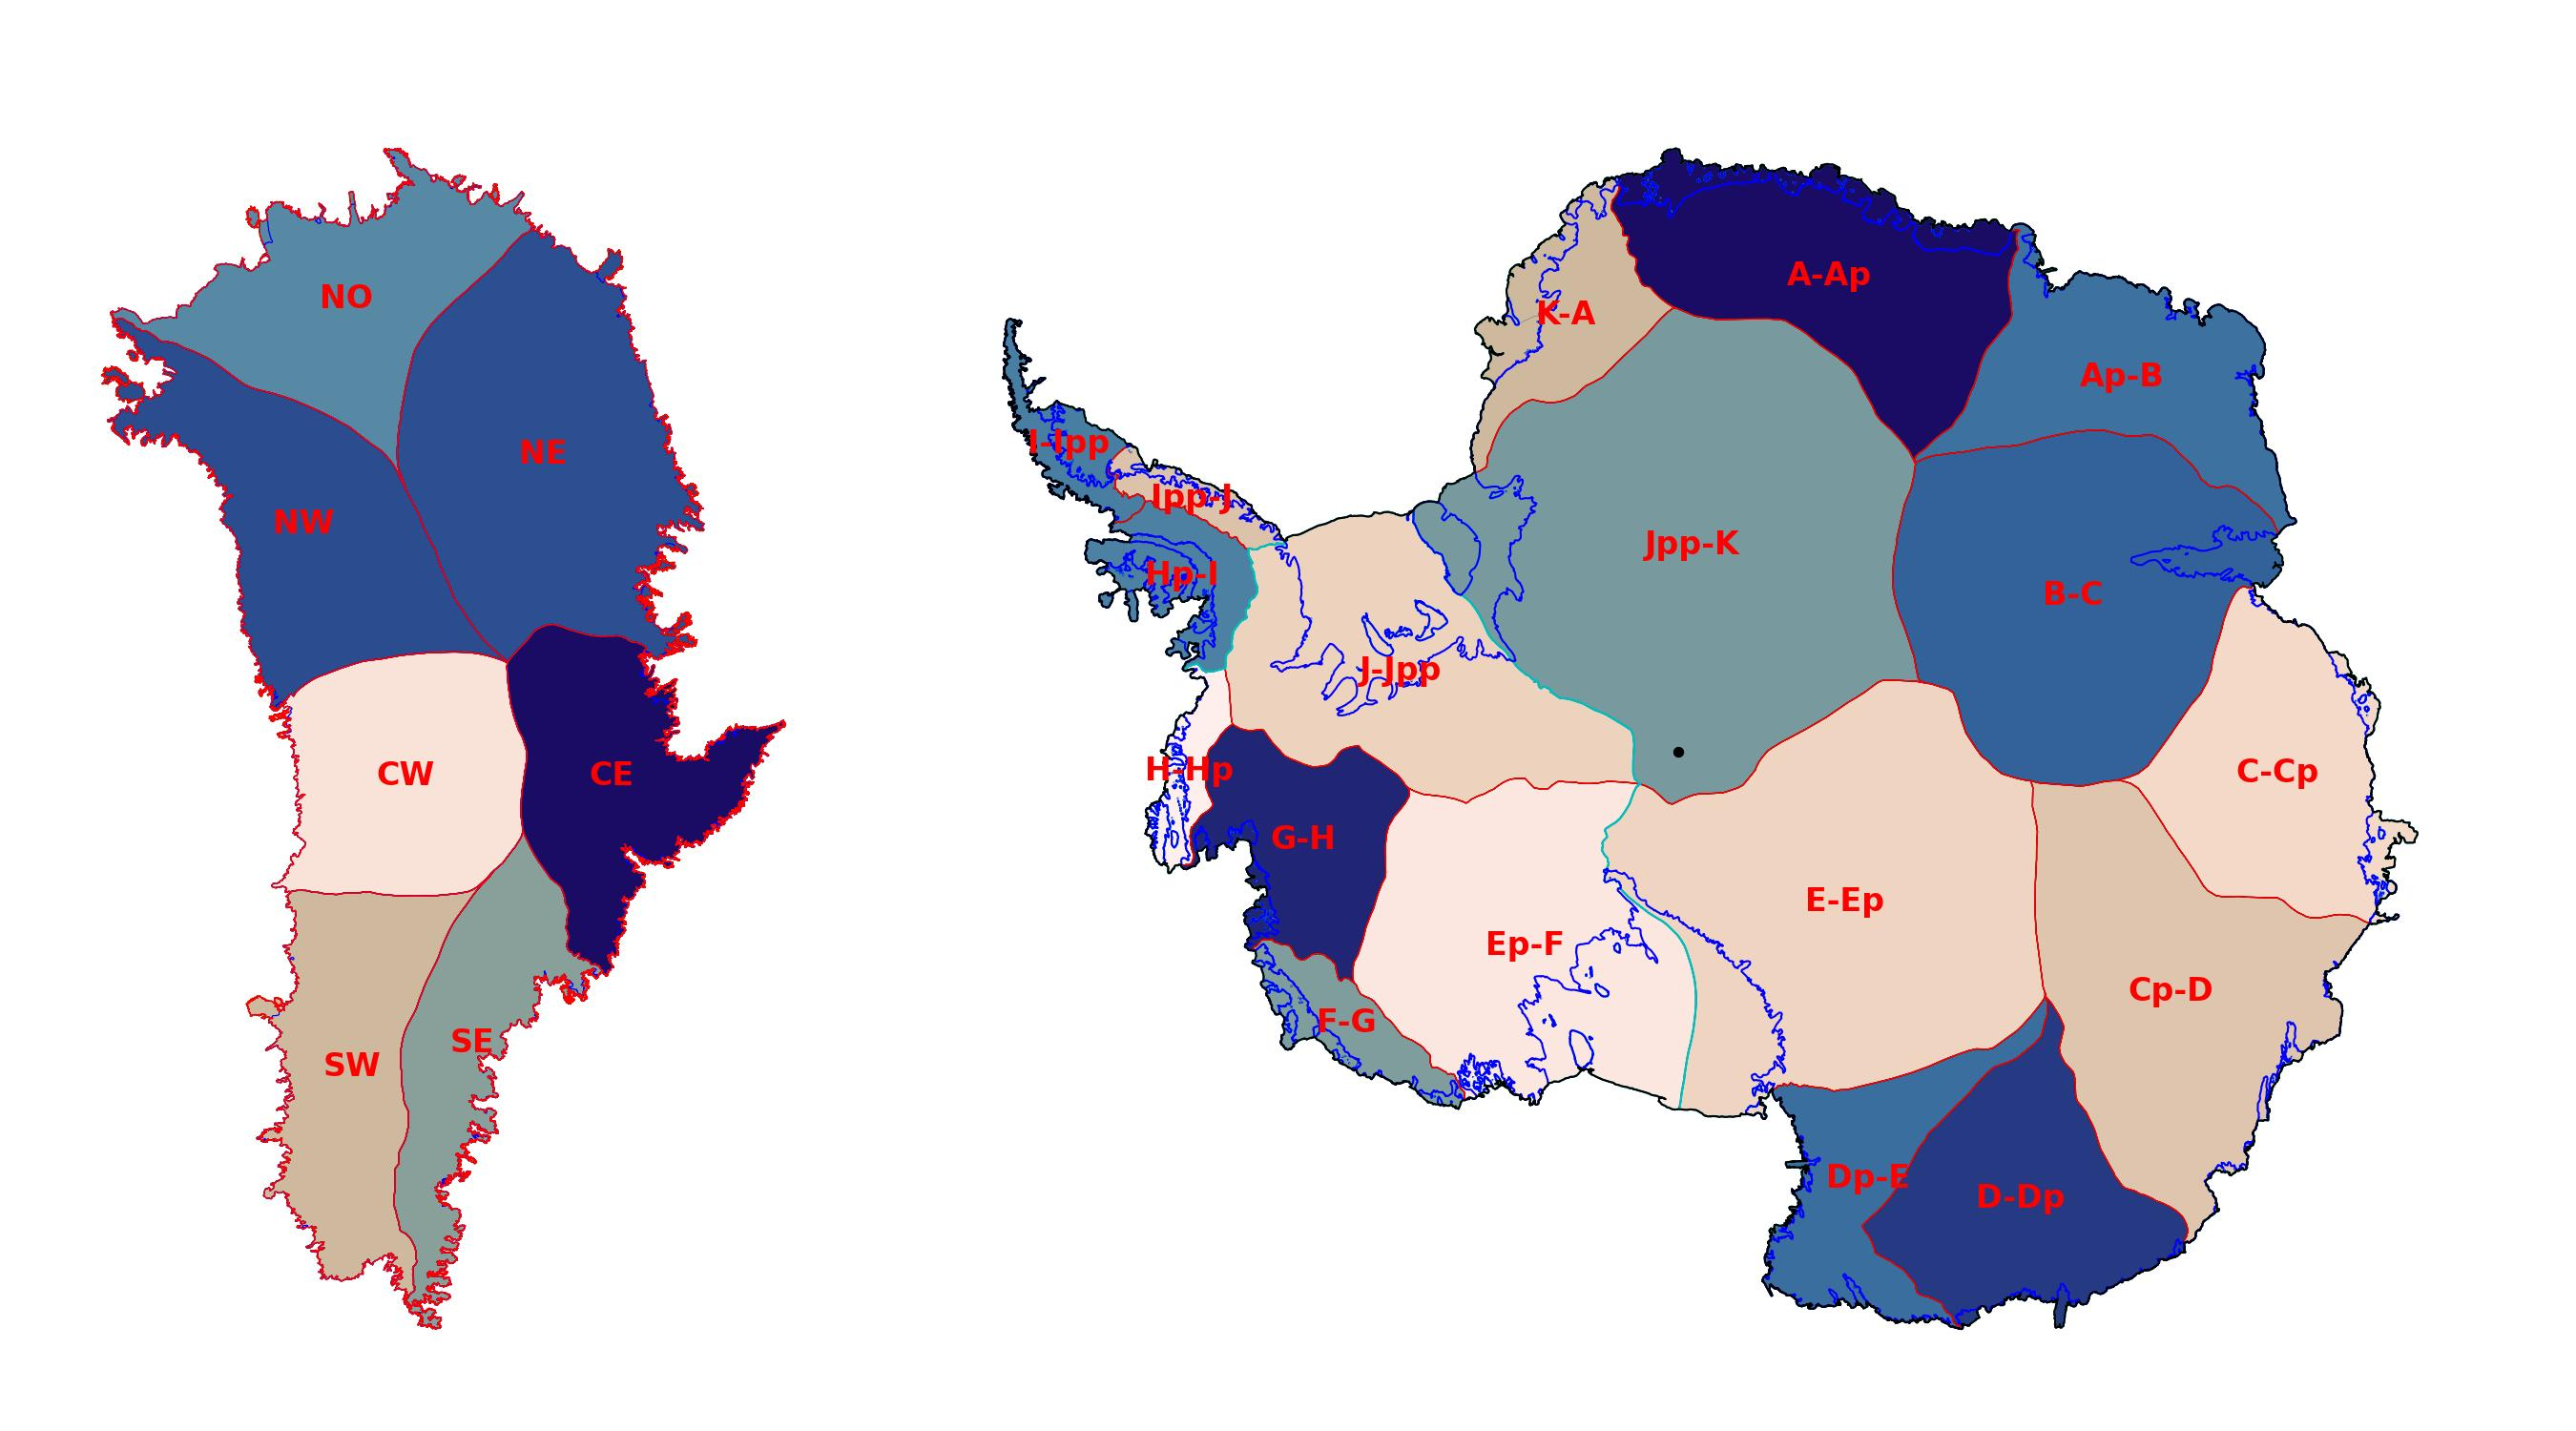

In [35]:
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_merged.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
ant_gdf_merged.boundary.plot(color='k', ax=ax, lw=0.3)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
ant_gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
ant_gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
ant_gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
ant_gdf_merged.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=3,color='k')
ax.set_title(' ')
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_merged.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gre_gdf_merged.boundary.plot(color='k', ax=ax, lw=0.3)
gre_gdf_regions.boundary.plot(color='b', ax=ax, lw=0.3)
gre_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gre_gdf_merged.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.set_title(' ')
ax.axis('off')

fig.tight_layout()

# show plot and print info
plotname = 'plots/merged_basins_both_sheets.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

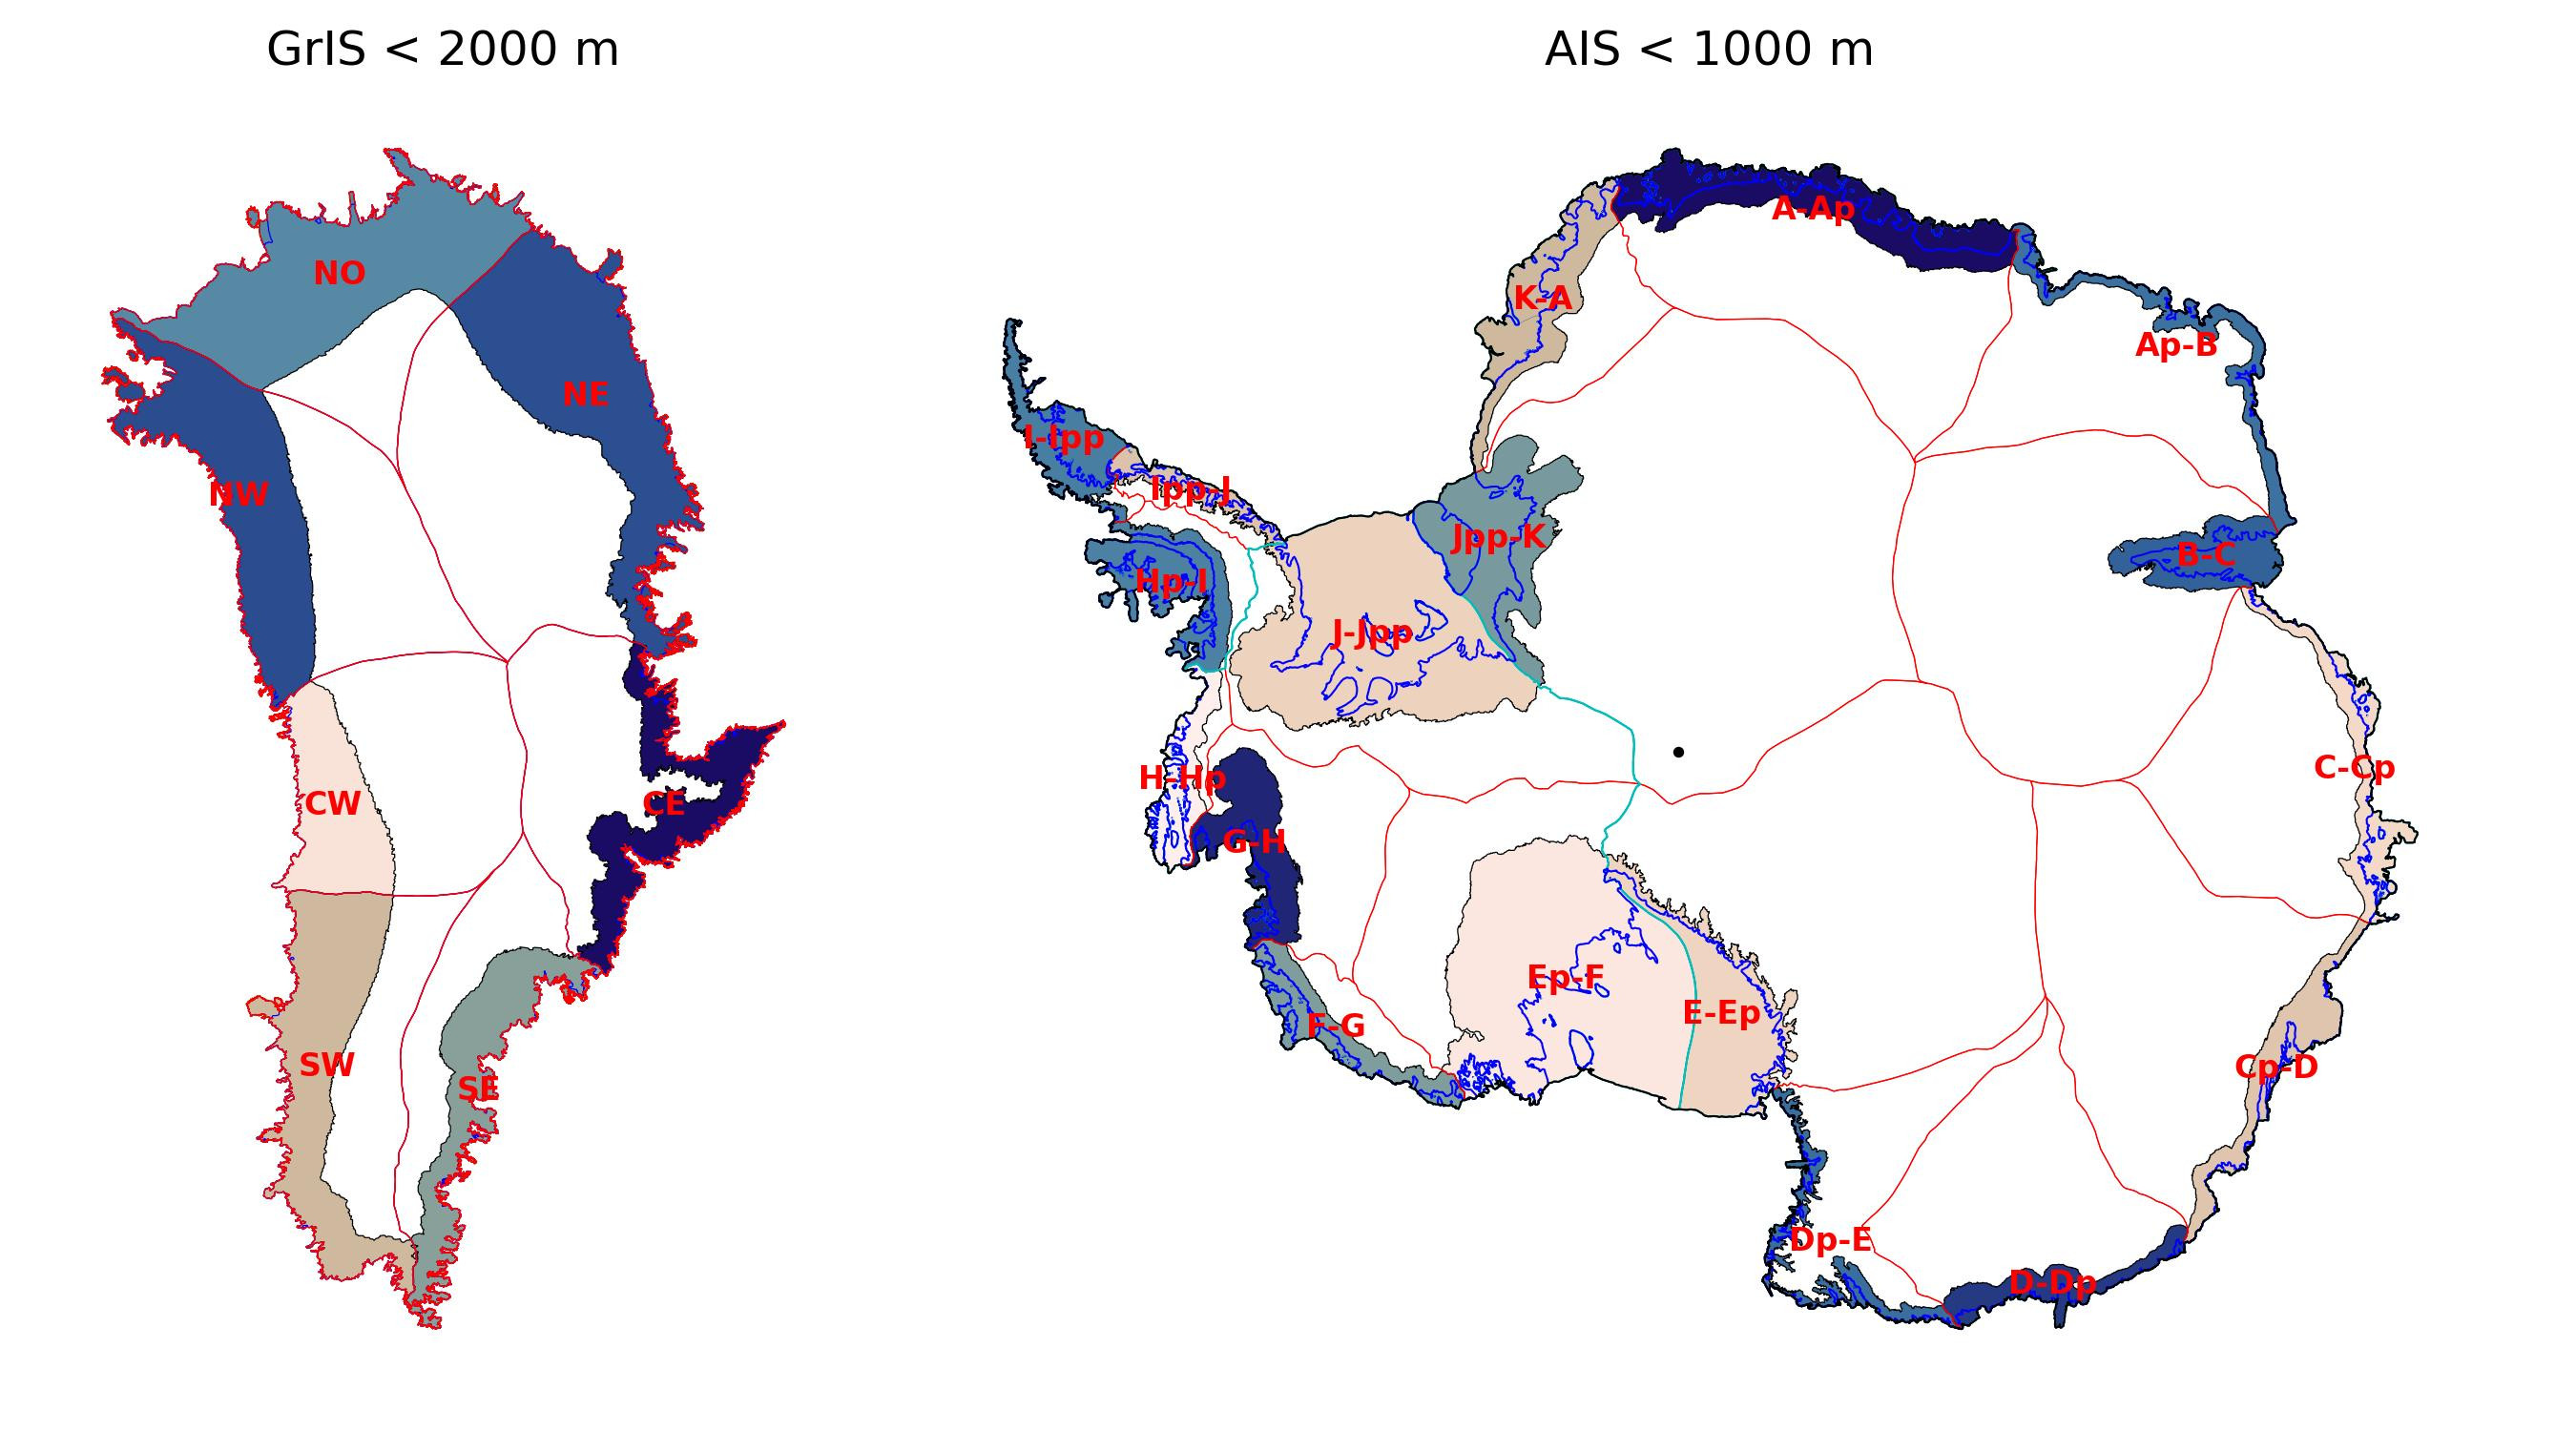

In [36]:
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_thresh_nofix.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
ant_gdf_thresh_nofix.boundary.plot(color='k', ax=ax, lw=0.3)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
ant_gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
ant_gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
ant_gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
ant_gdf_thresh_nofix.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=3,color='k')
ax.set_title('AIS < 1000 m')
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gre_gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gre_gdf_regions.boundary.plot(color='b', ax=ax, lw=0.3)
gre_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gre_gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.set_title('GrIS < 2000 m')
ax.axis('off')

fig.tight_layout()

# show plot and print info
plotname = 'plots/thresholded_basins_both_sheets.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))

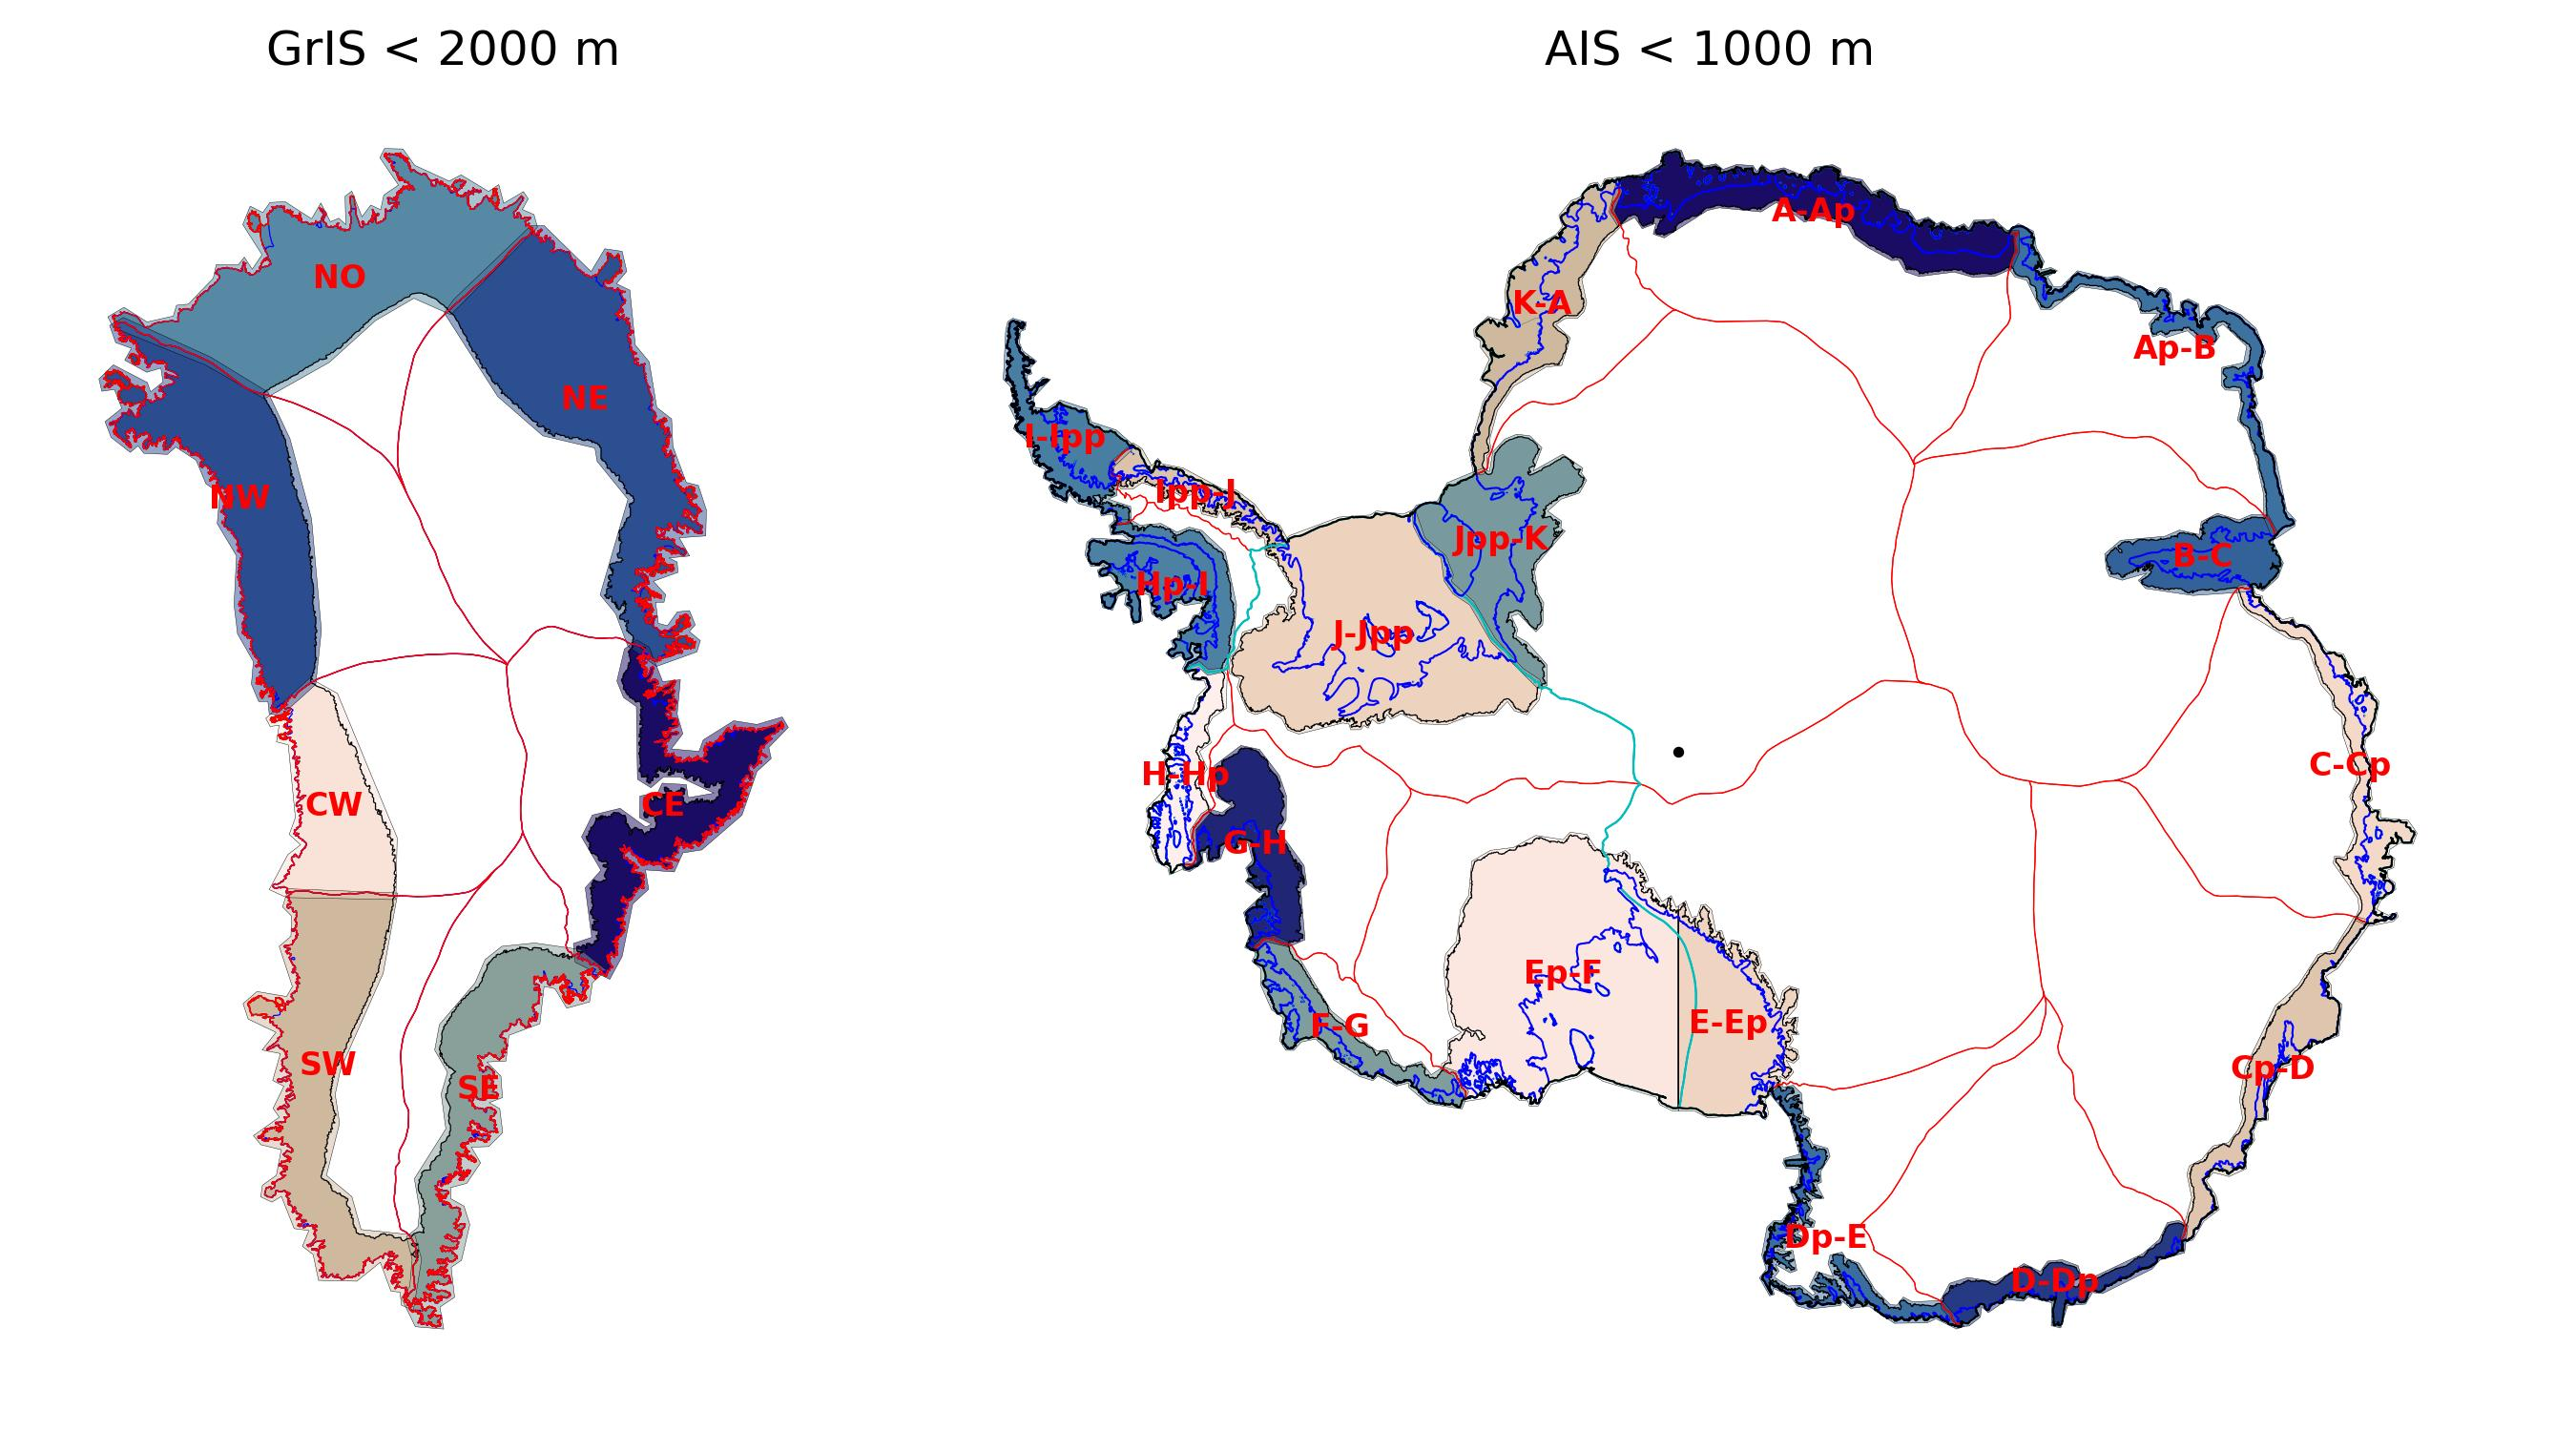

In [37]:
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
ant_gdf_thresh_simple.plot(column='Subregions', cmap=cmc.lapazS, alpha=0.5, ax=ax)
ant_gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
ant_gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
ant_gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
ant_gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
ant_gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
ant_gdf_thresh_simple.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=3,color='k')
ax.set_title('AIS < 1000 m')
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gre_gdf_thresh_simple.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax, alpha=0.5)
gre_gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gre_gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gre_gdf_regions.boundary.plot(color='b', ax=ax, lw=0.3)
gre_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gre_gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.set_title('GrIS < 2000 m')
ax.axis('off')

fig.tight_layout()
# show plot and print info
plotname = 'plots/thresholded_basins_both_sheets_NSIDC_simplified.jpg'
fig.savefig(plotname , dpi=300)
plt.close(fig)
display(Image(plotname))